In [1]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [2]:
get_x_test <- function(forecast_obj, frequency) {
    encode <- seq(0, 1, length.out = frequency + 1)[1:frequency]
    ts_obj <- forecast_obj$mean
    seq_start <- start(ts_obj)[1] + encode[start(ts_obj)[2]]
    seq_end <- end(ts_obj)[1] + encode[end(ts_obj)[2]]
    return(seq(seq_start, (seq_start + seq_end) / 2, length.out = k))
}

Разбиваем выборку на тестовую и обучающую часть и делаем из данных временной ряд.

In [3]:
data <- read.table('3.txt', sep = ' ')$V6
k <- 20
train <- data[1:(length(data) - k)]
test <- data[(length(data) - k + 1):length(data)]

Смотрим на предсказания с экспоненциальным сглаживанием. Зеленый цвет - реальные значения. Синие - предсказания. Перебираем сезональности, ищем лучший вариант.

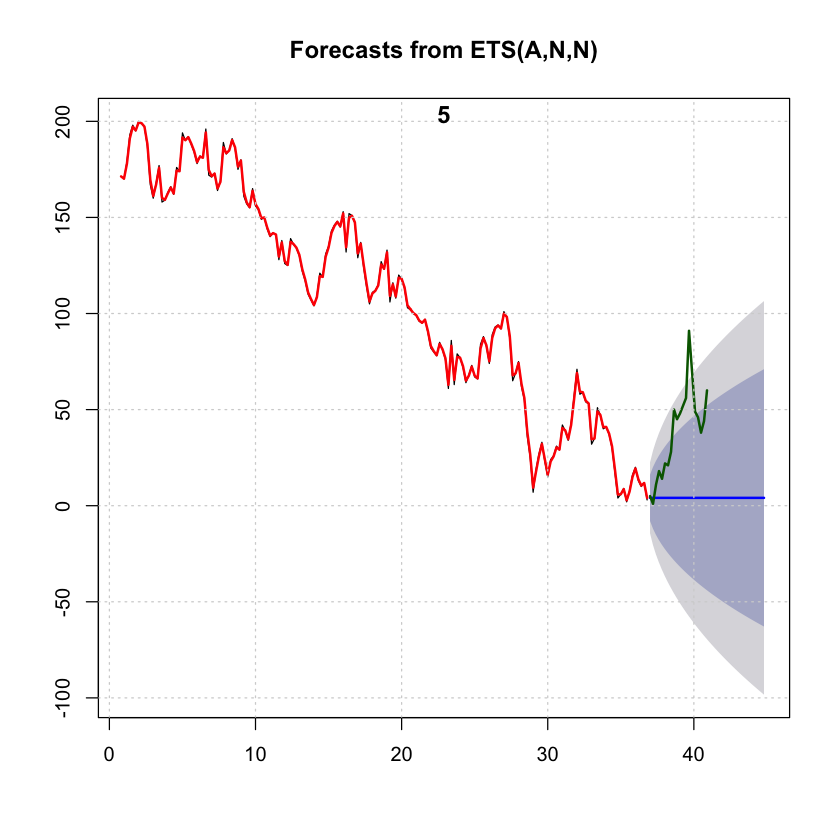

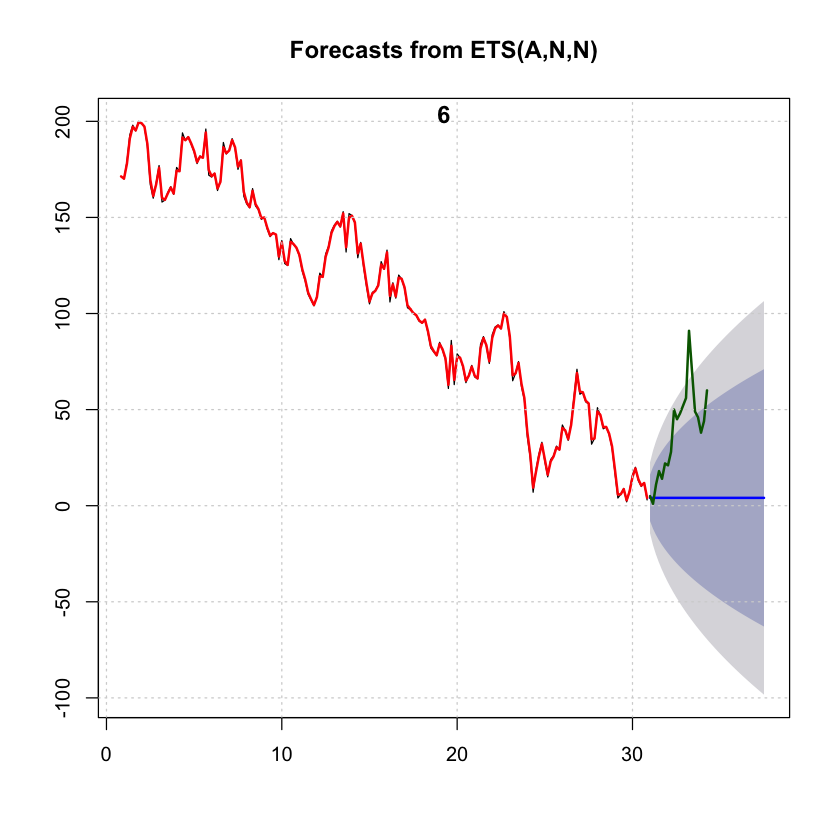

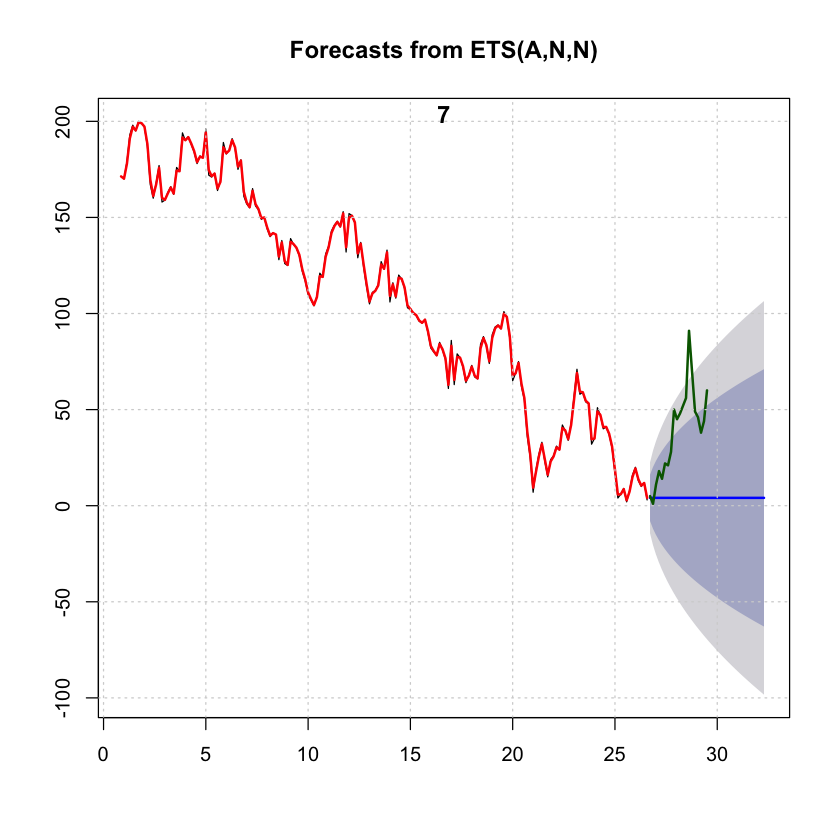

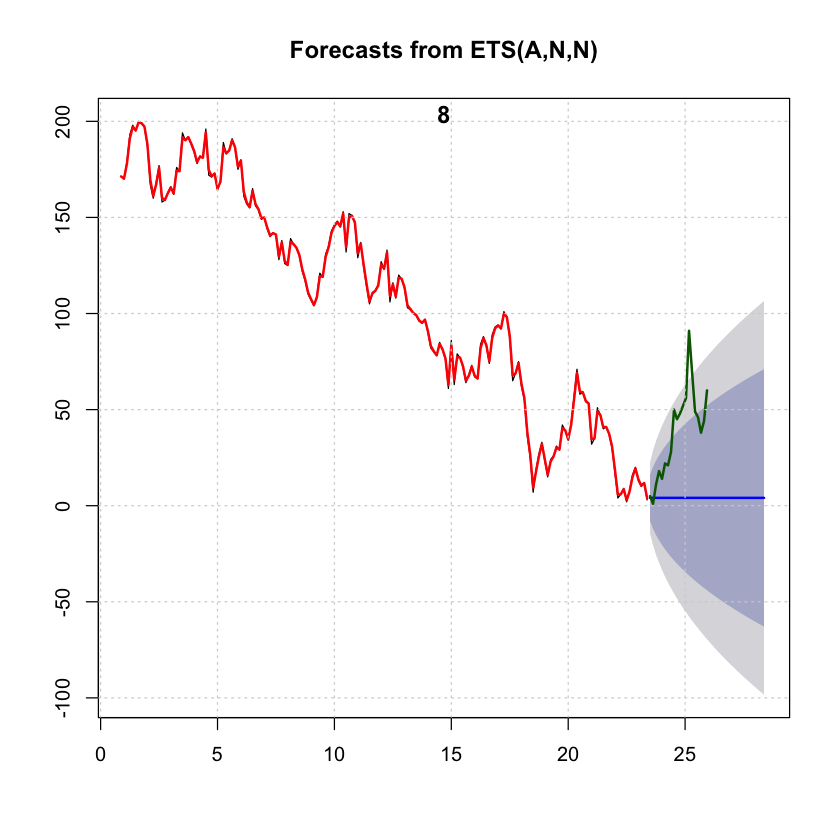

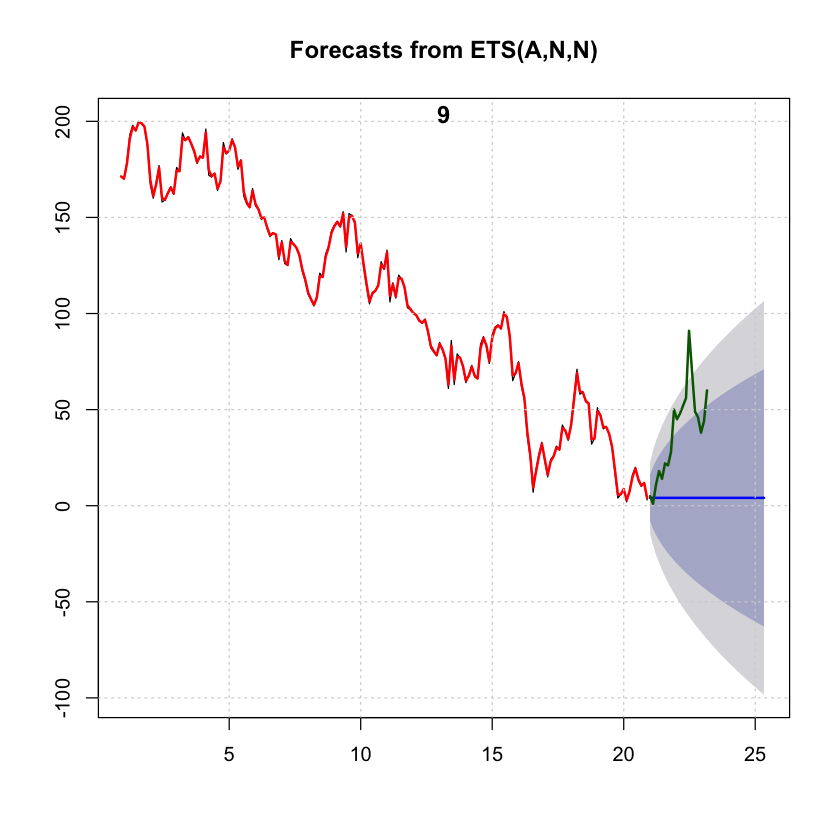

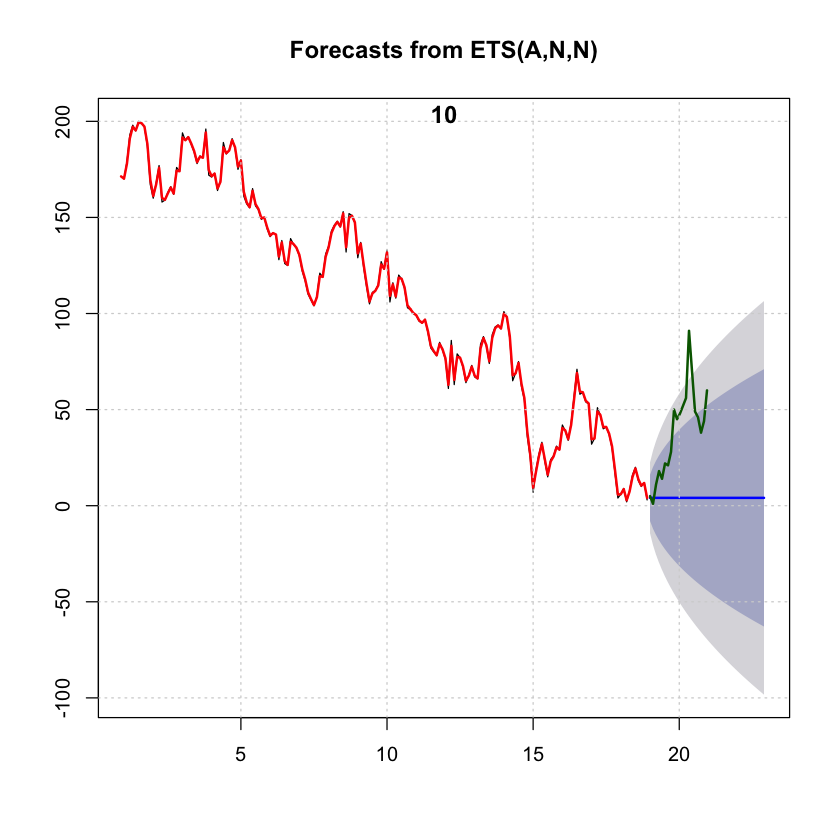

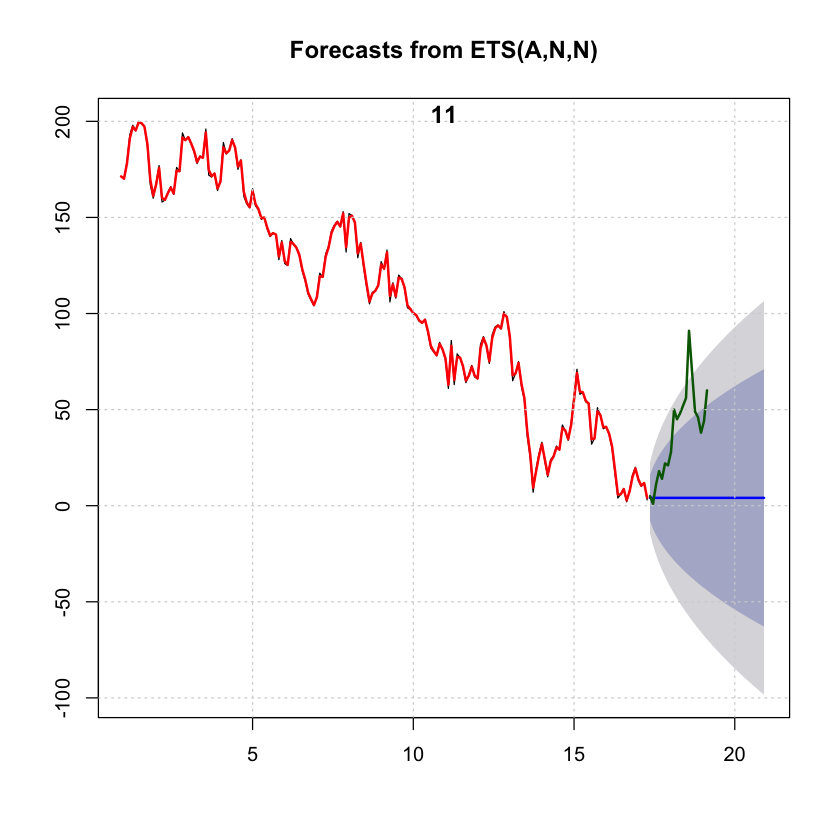

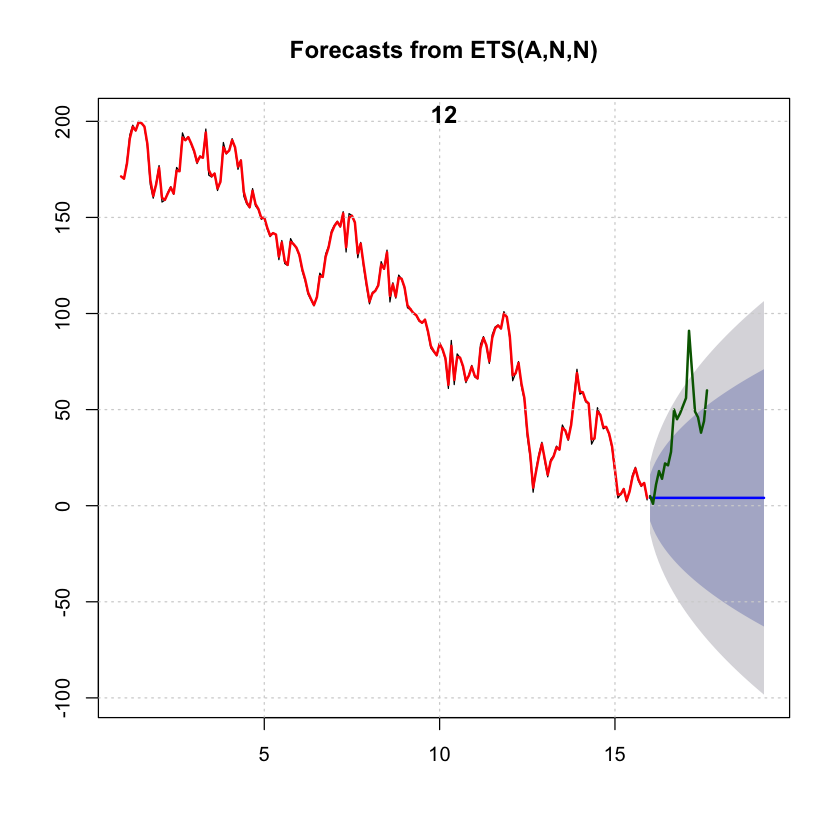

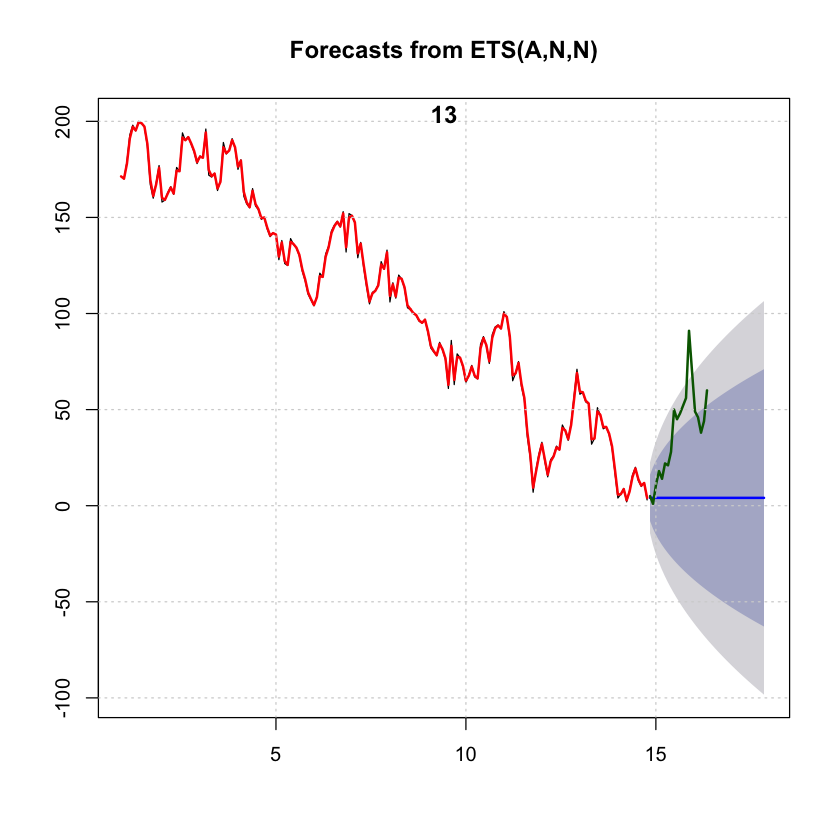

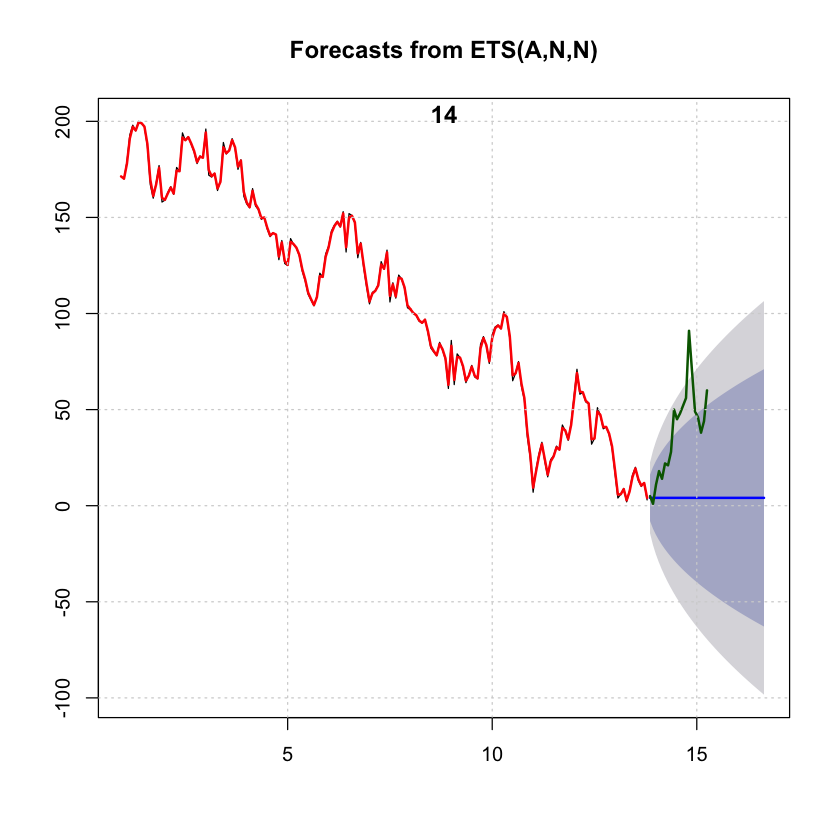

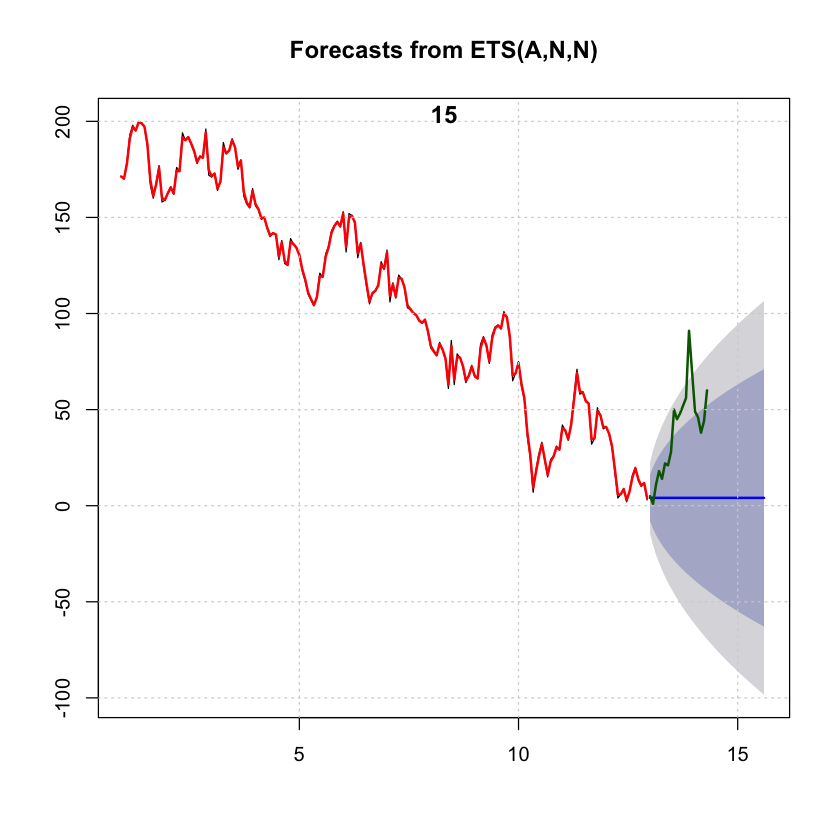

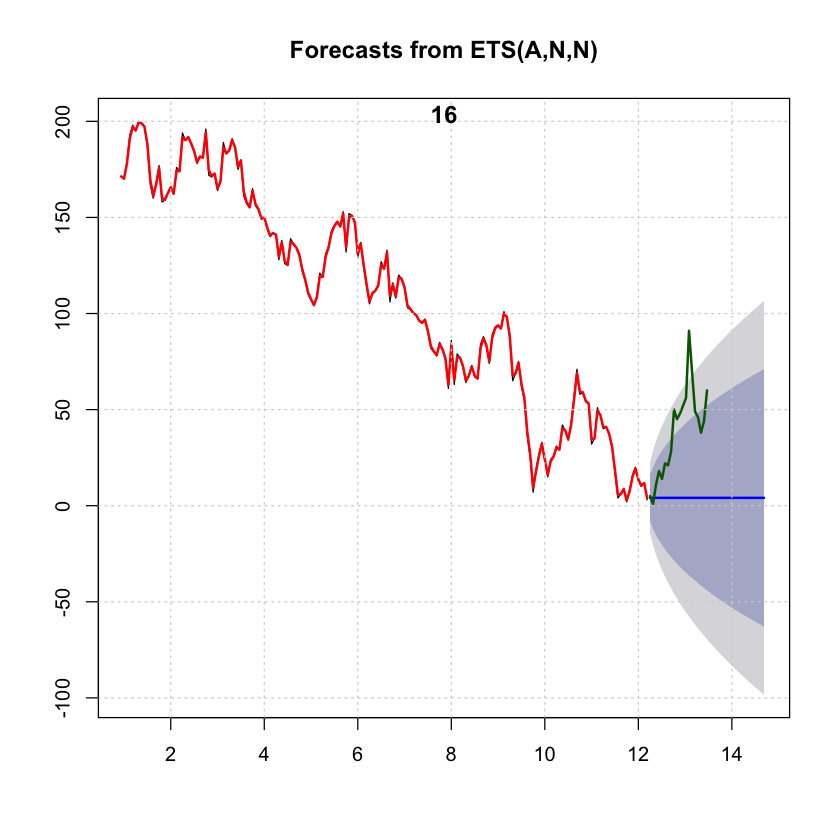

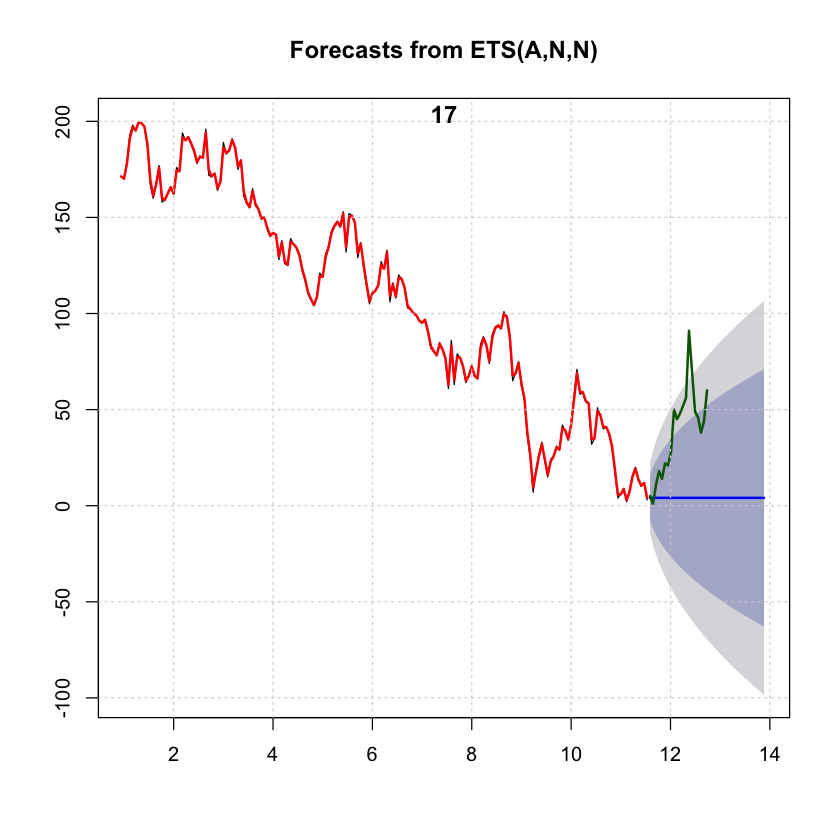

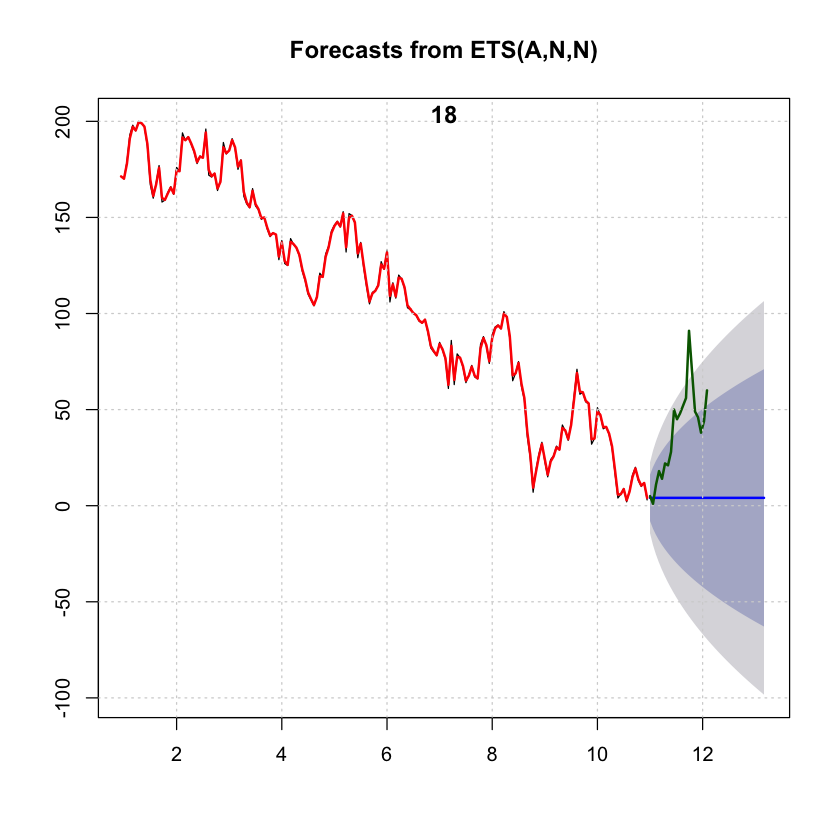

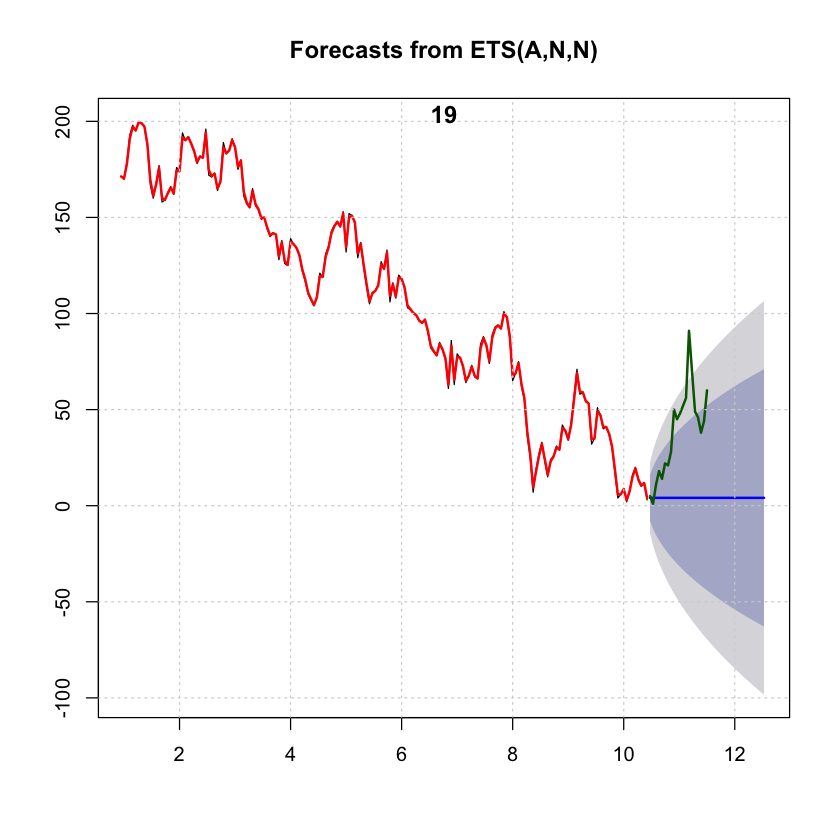

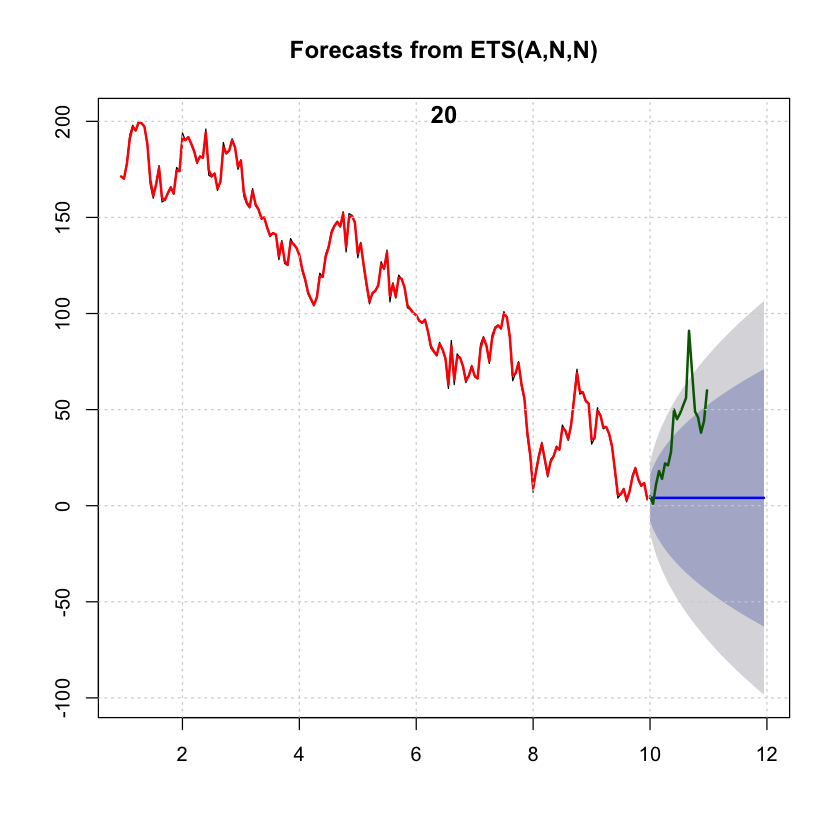

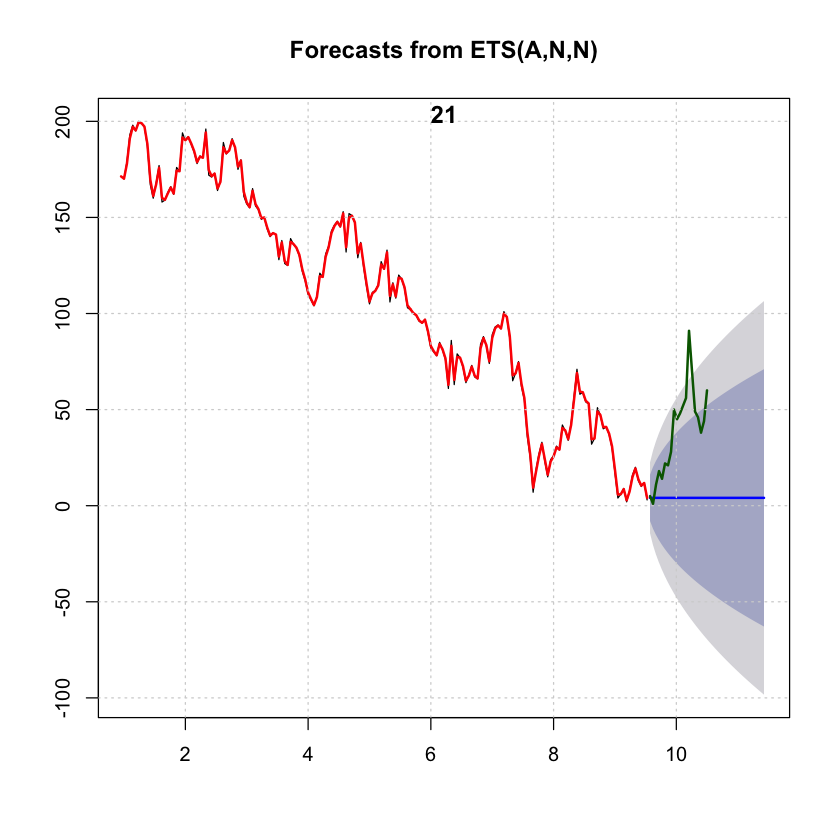

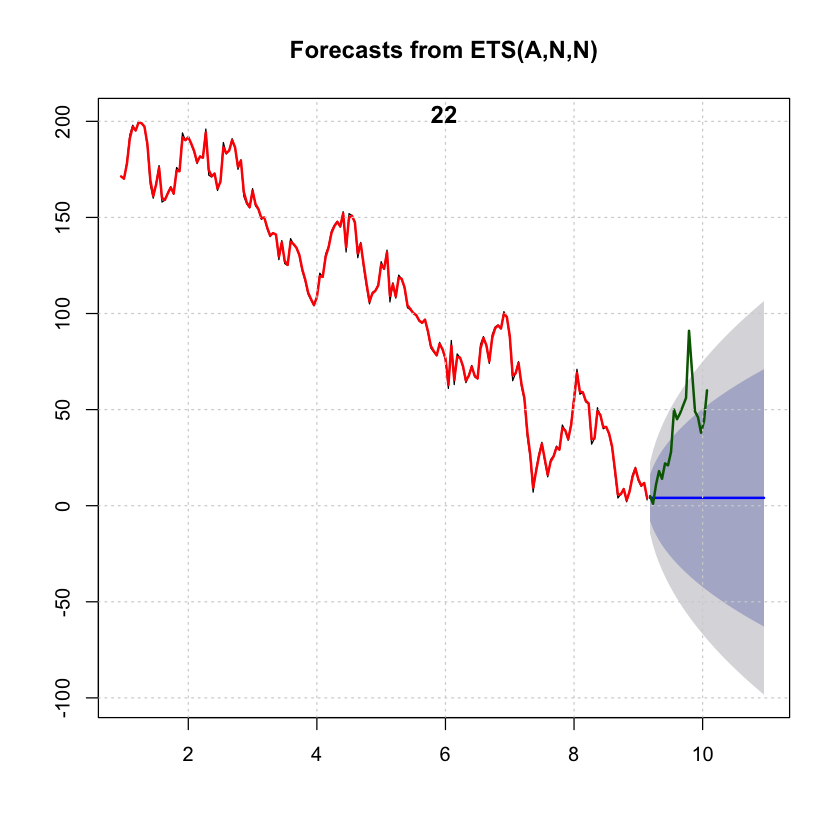

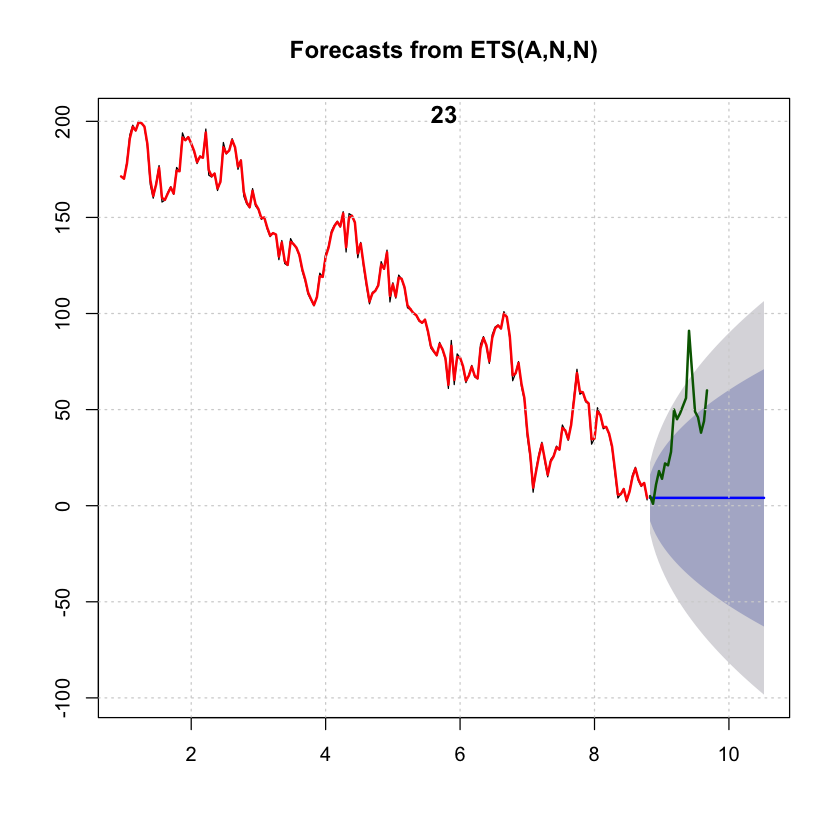

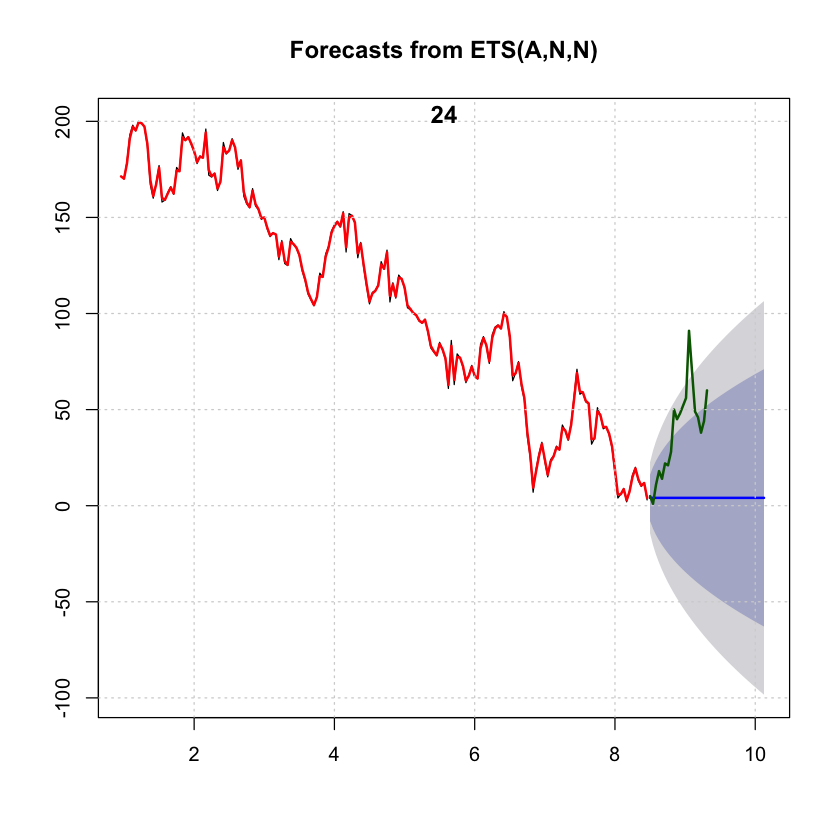

In [4]:
for (frequency in 5:24) {
    tSeries <- ts(data = train, frequency = frequency)
    fit_ets <- ets(tSeries)
    etc_forecast <- forecast(fit_ets, h = 2 * k)
    x_test = get_x_test(etc_forecast, frequency = frequency)
    plot(etc_forecast)
    lines(x_test, test, col = 'dark green', lwd = 2)
    lines(fit_ets$states[, 1], col = 'red', lwd = 2)
    grid()
    title(frequency, line = -1)
}

Для экспоненциального сглаживания при любых периодах результат получился плохой. Попробуем другие способы.

То же самое с ARIMA

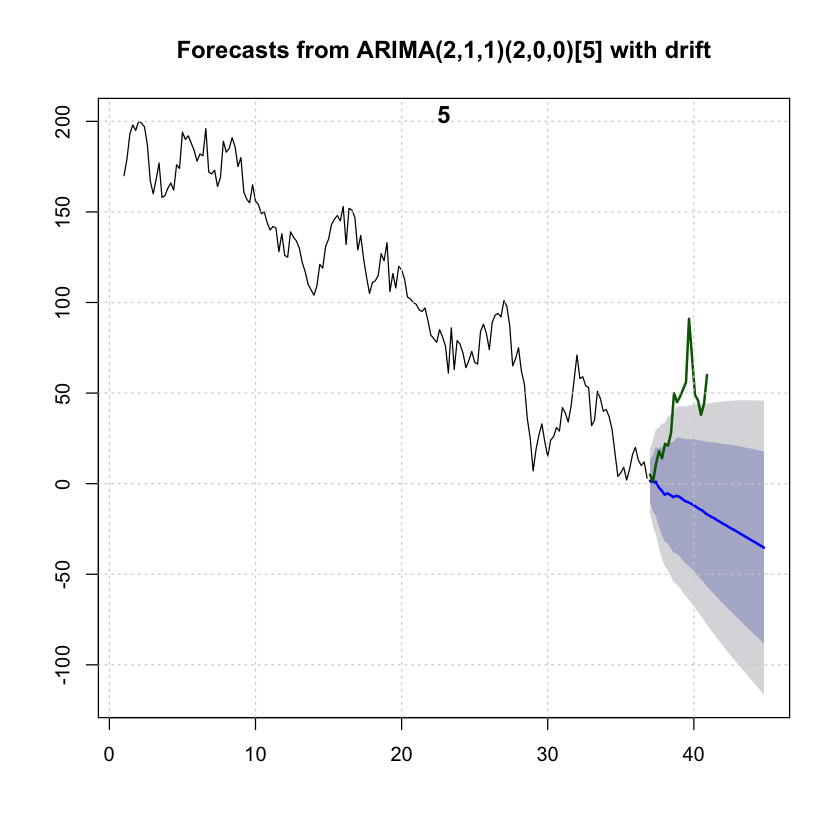

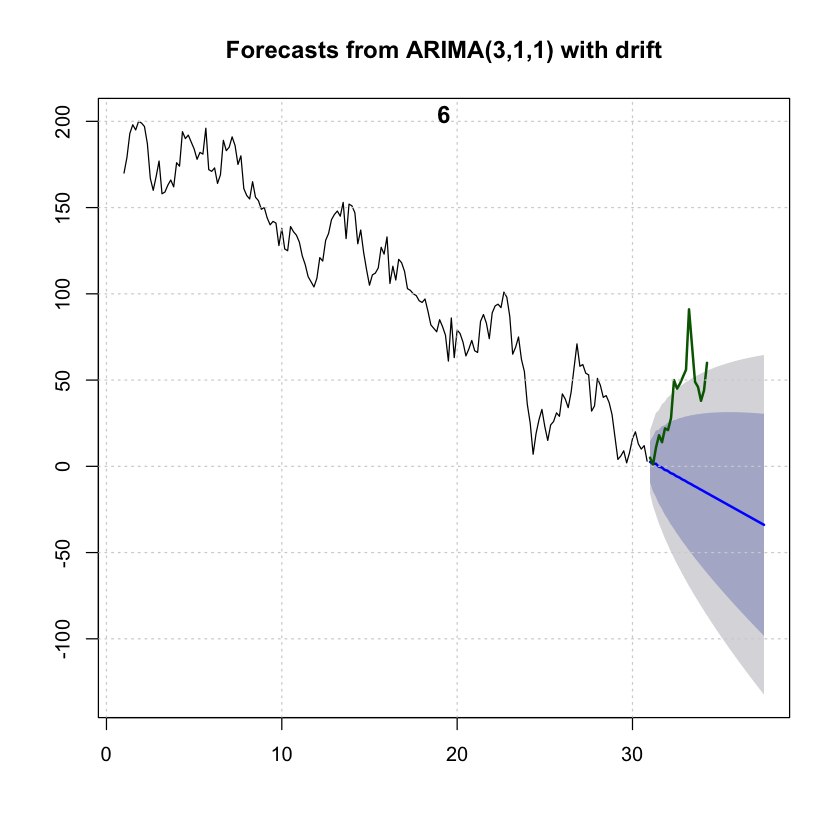

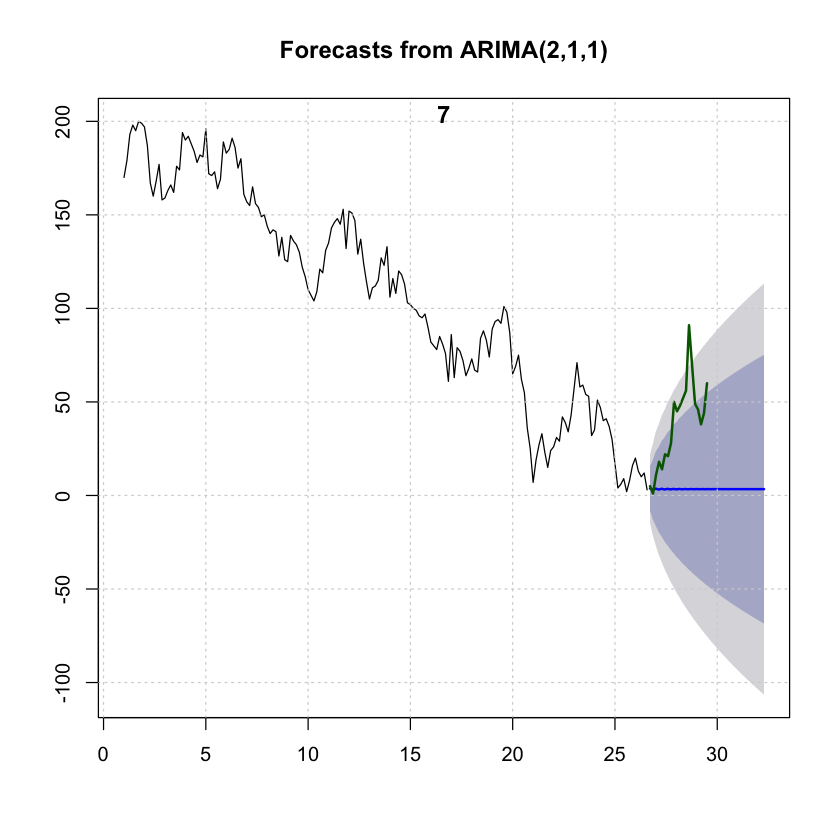

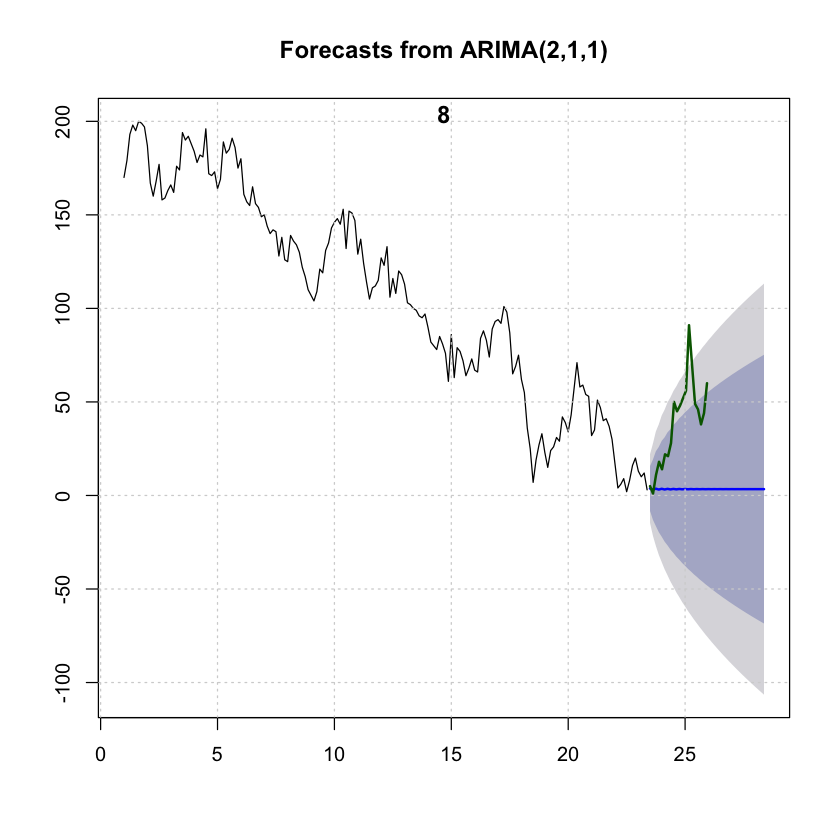

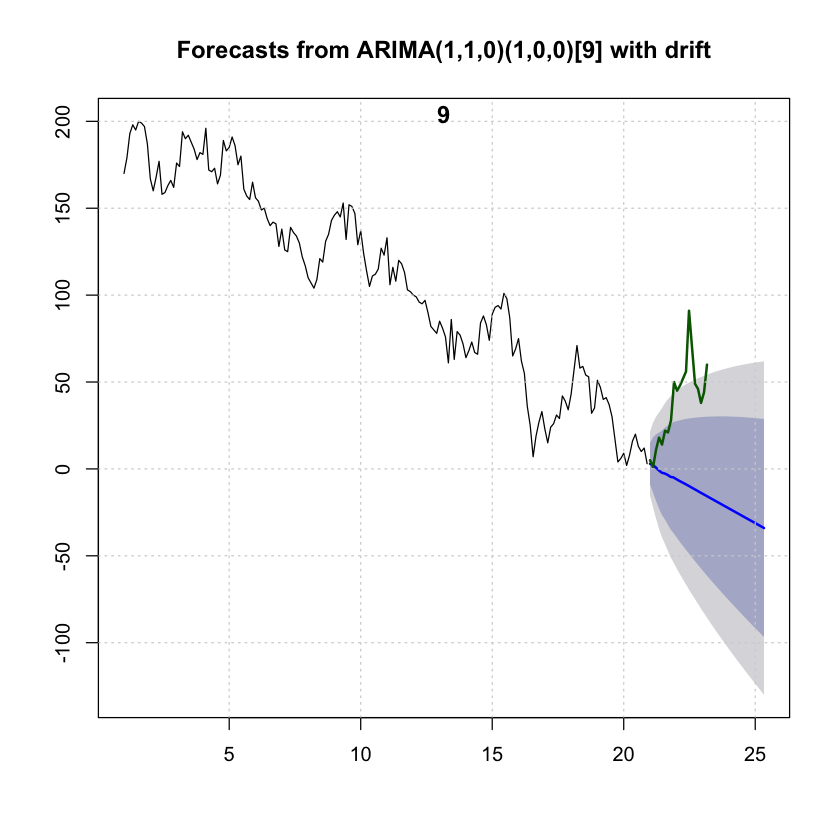

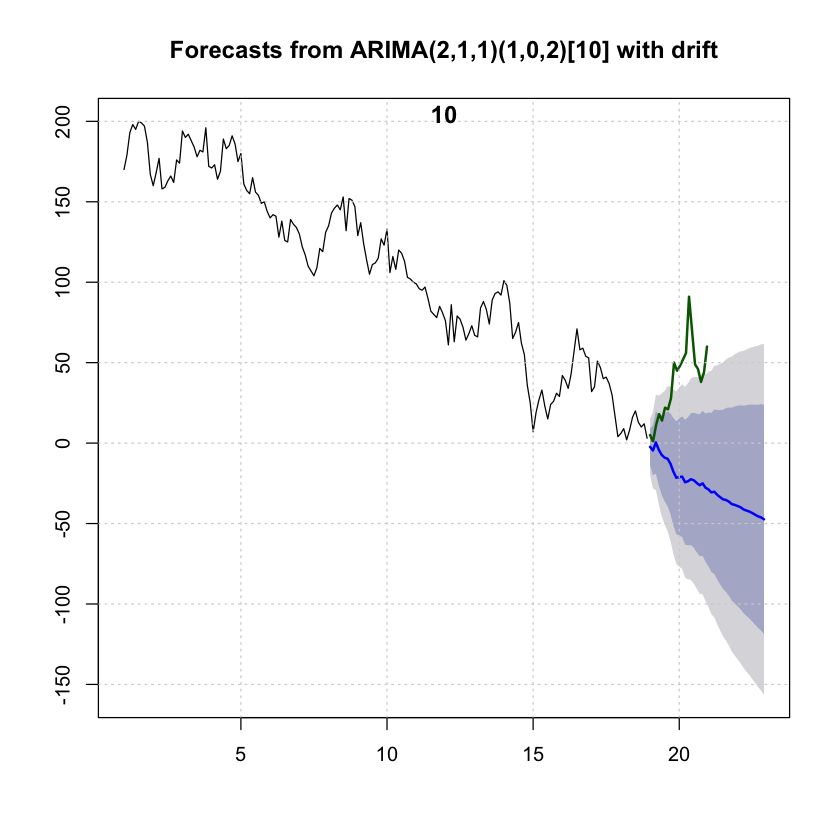

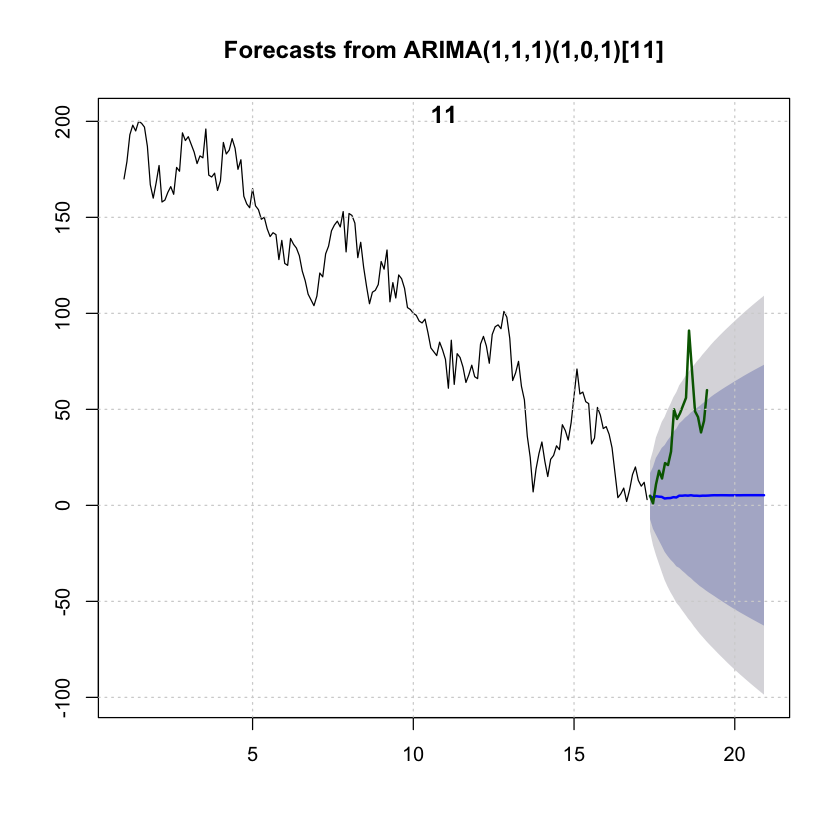

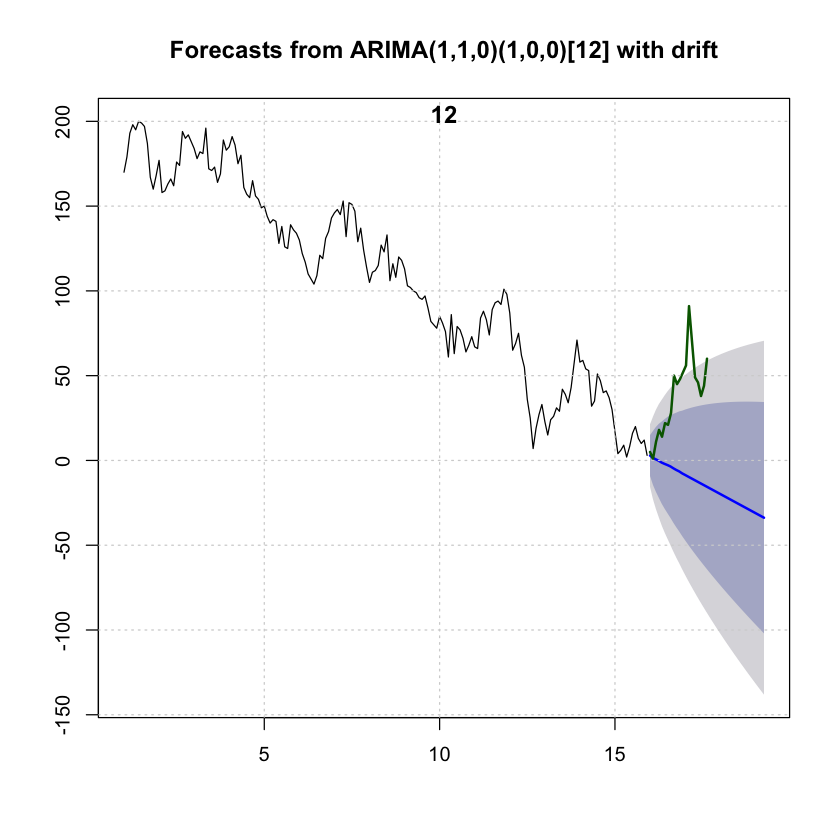

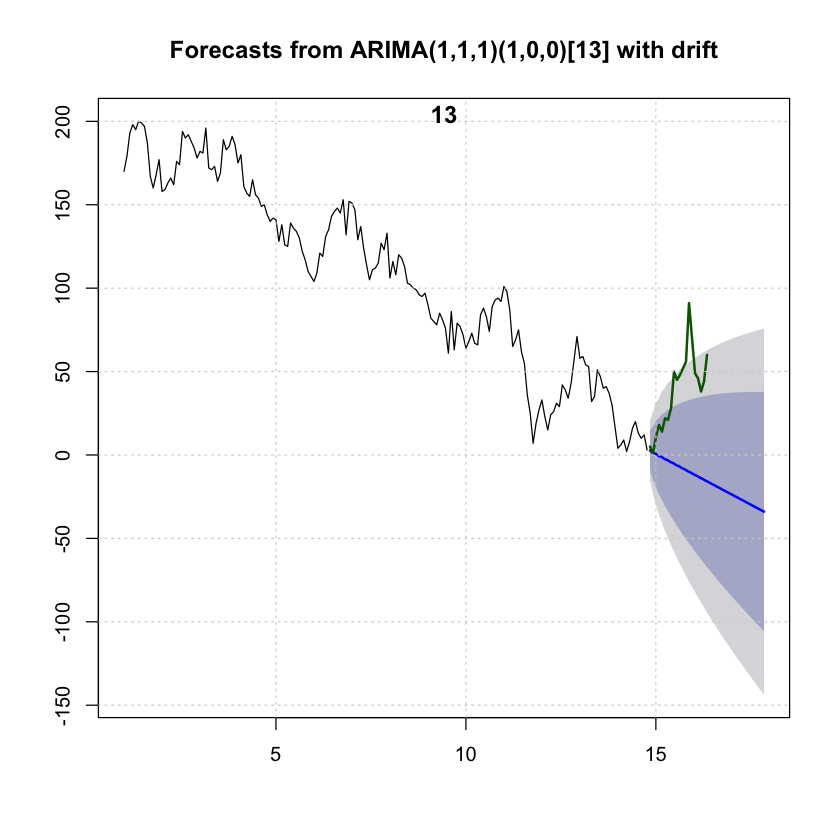

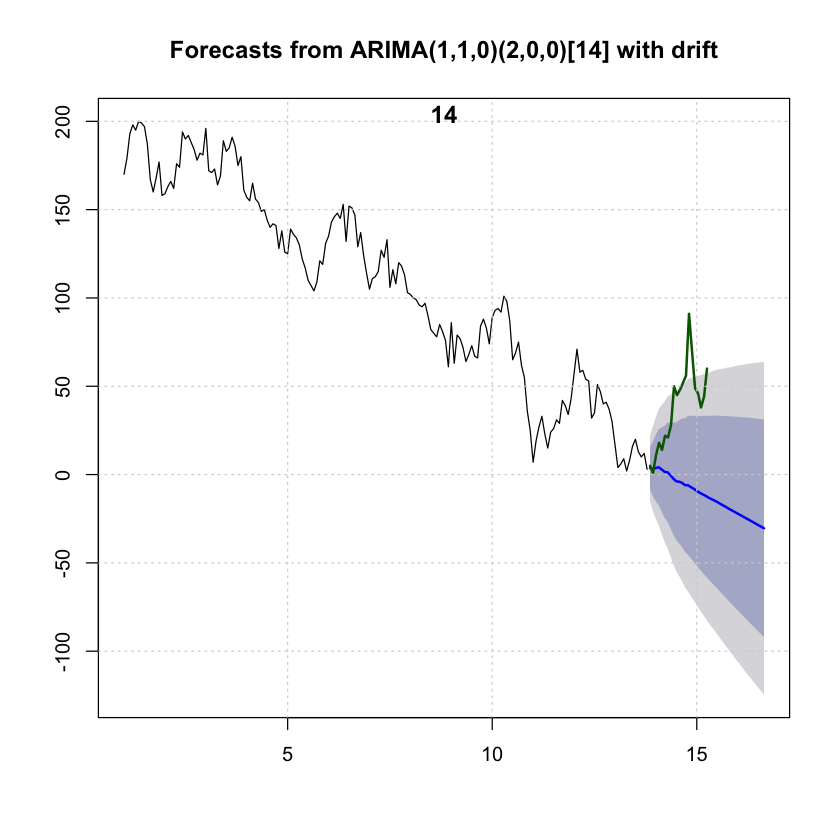

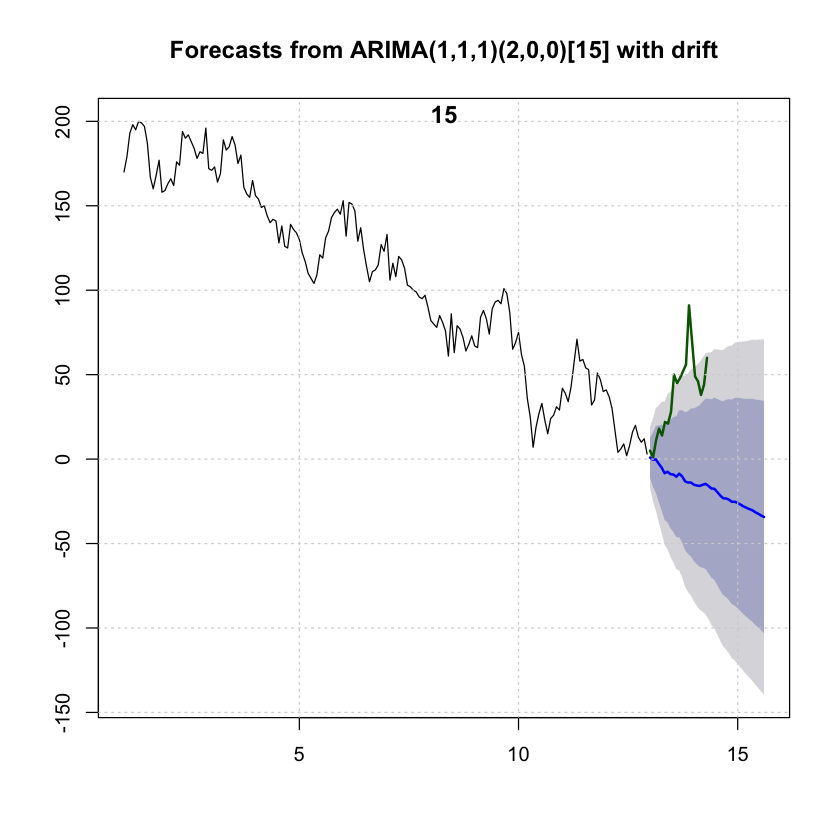

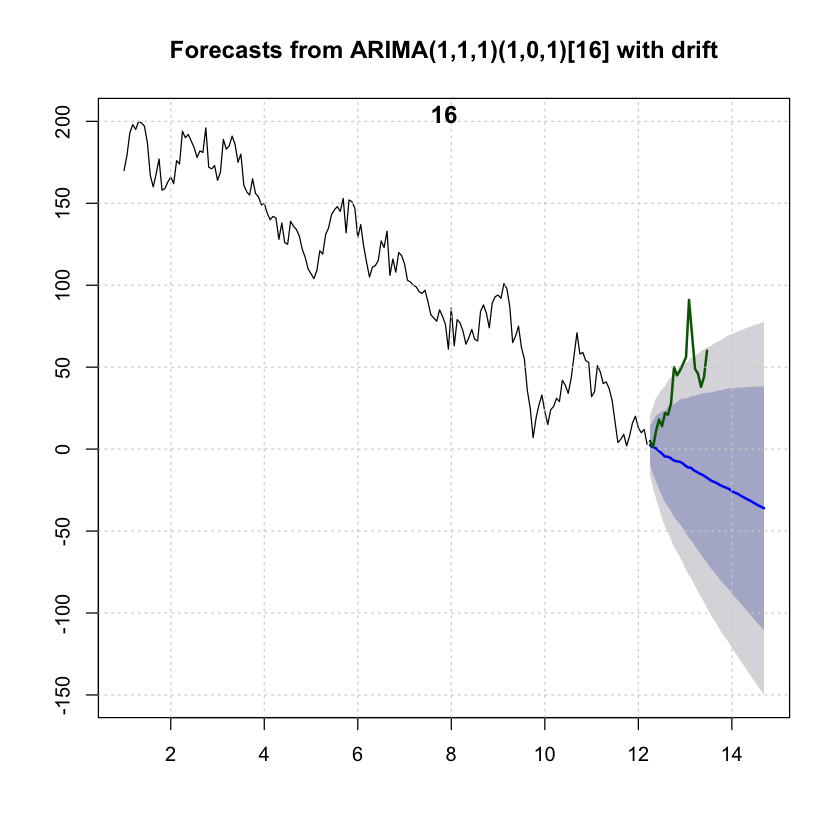

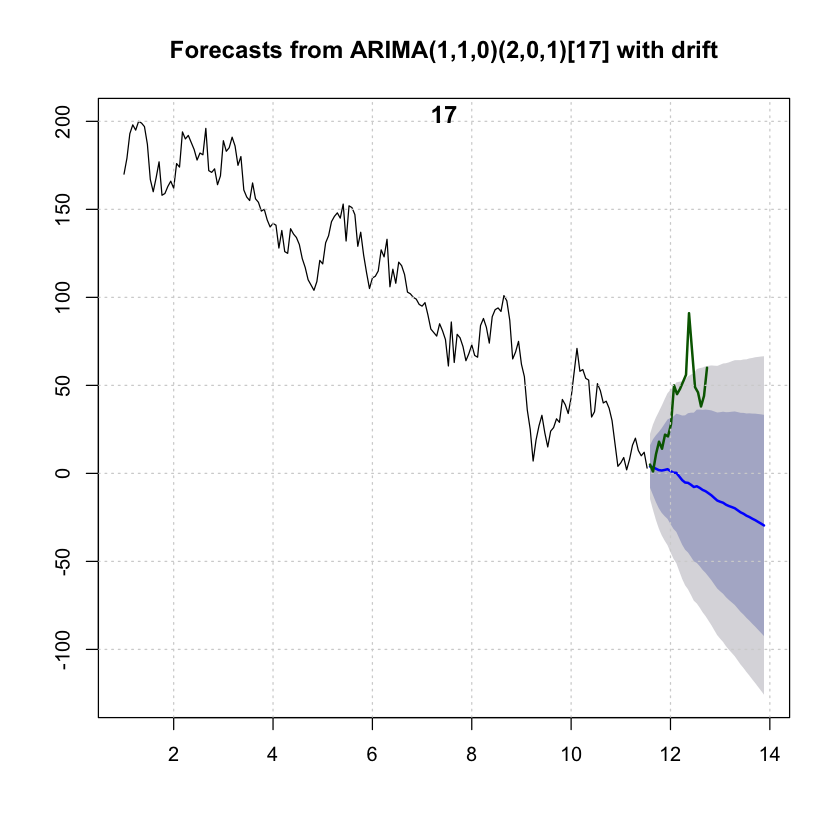

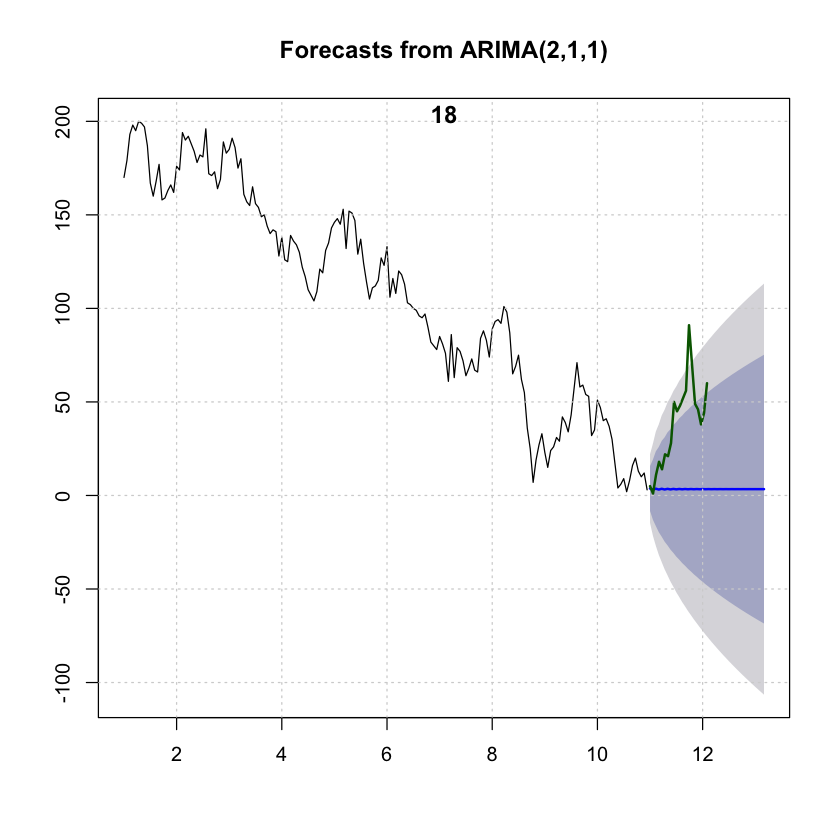

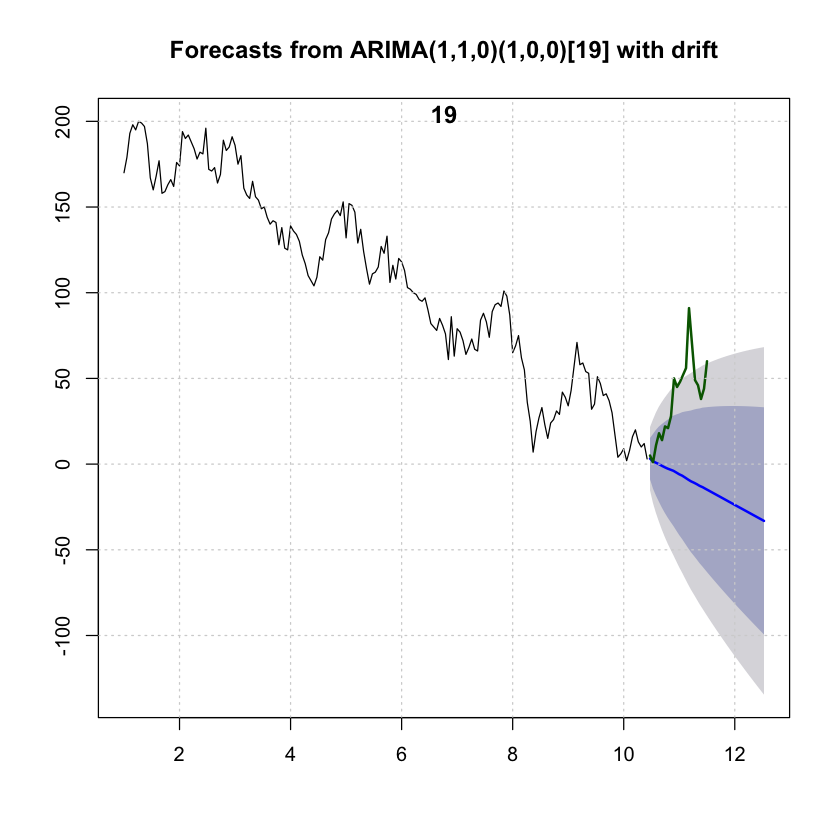

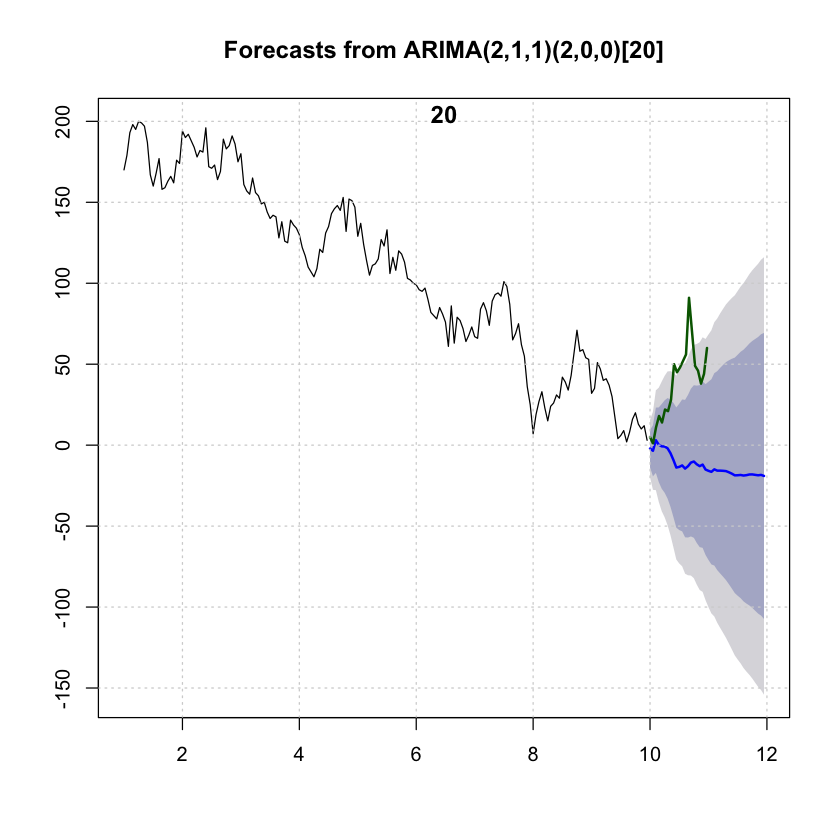

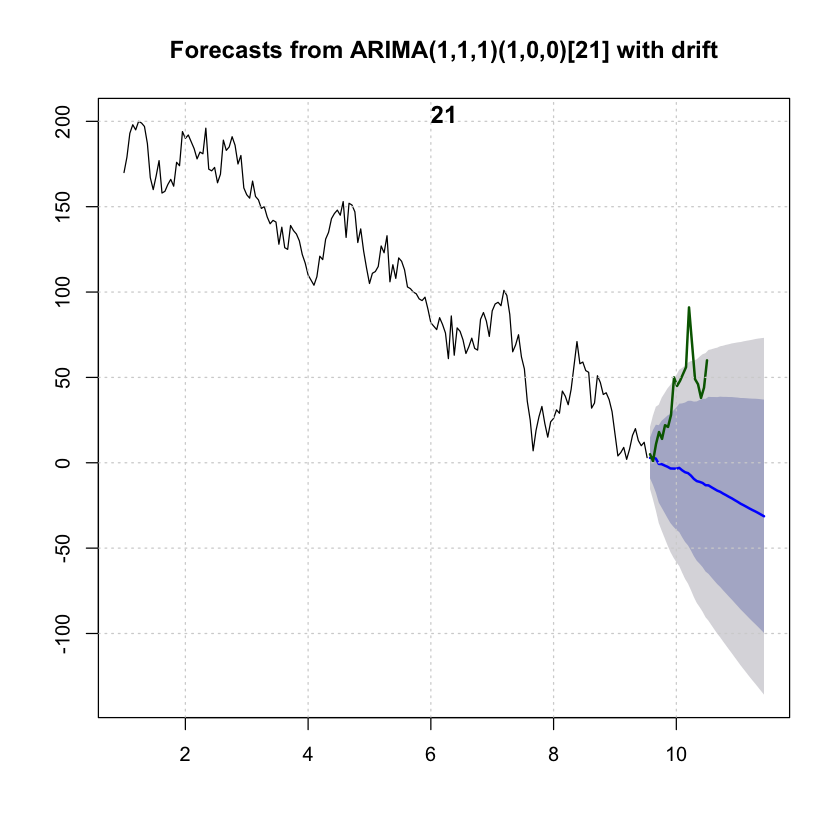

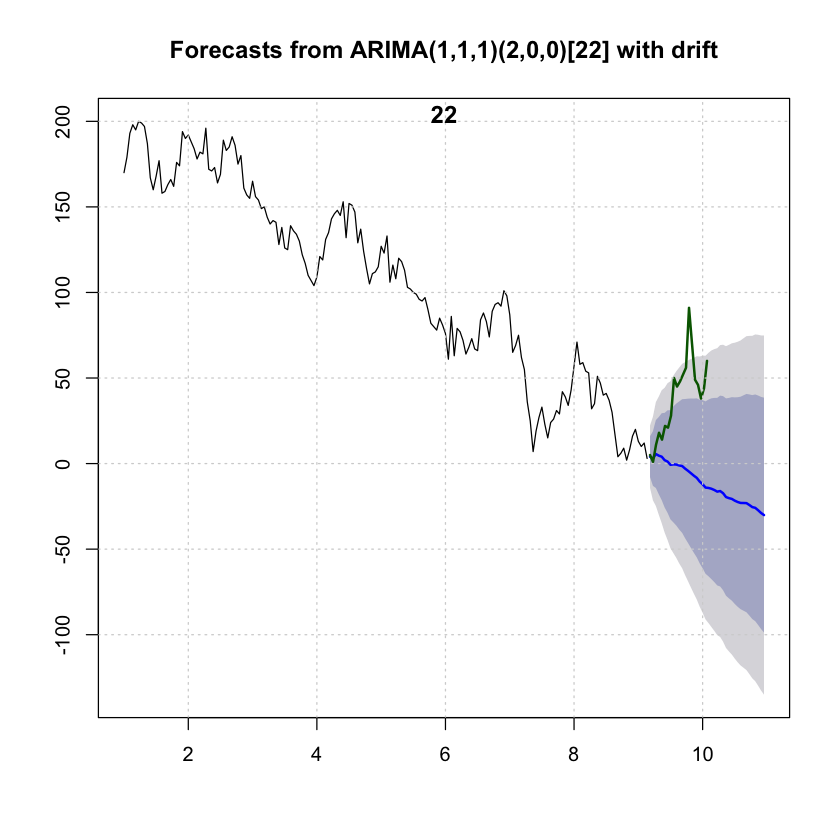

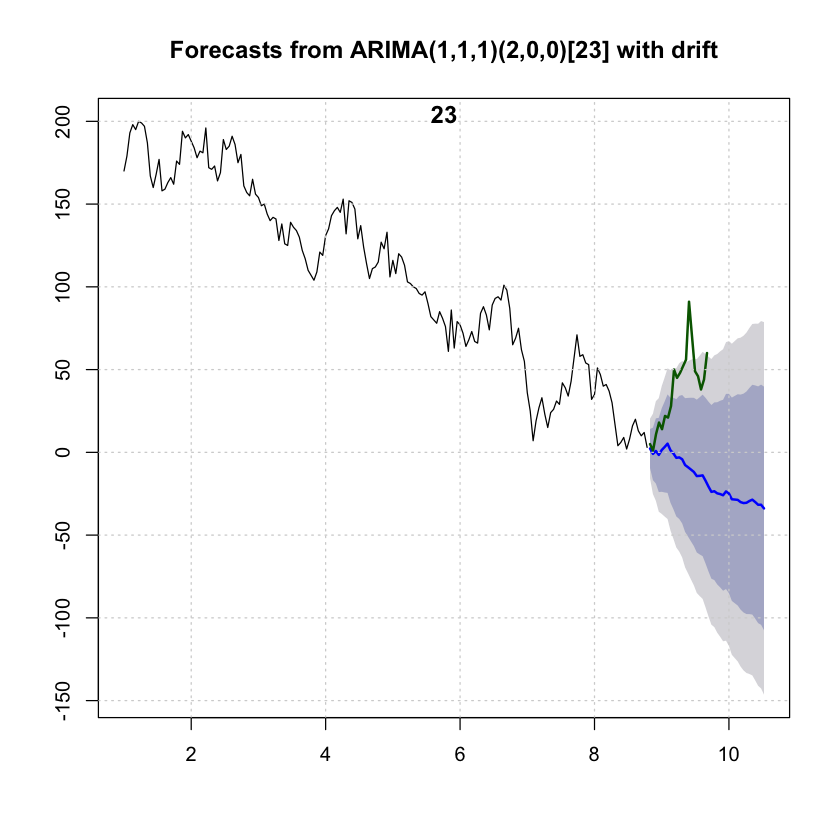

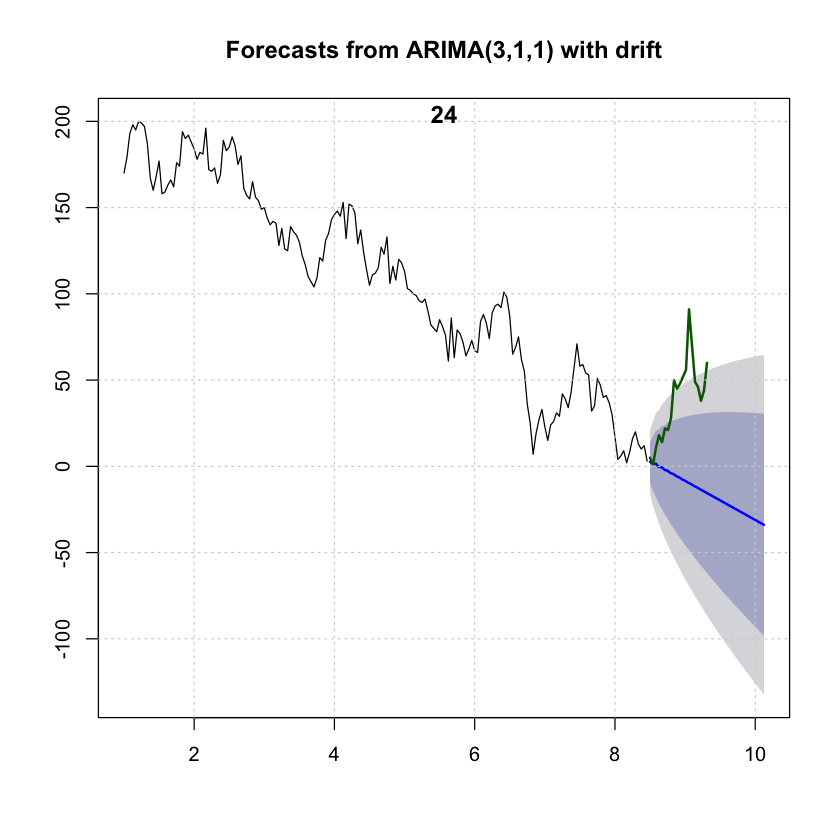

In [5]:
for (frequency in 5:24) {
    tSeries <- ts(data = train, frequency = frequency)
    fit_arima <- auto.arima(tSeries)
    arima_forecast <- forecast(fit_arima, h = 2 * k)
    x_test = get_x_test(arima_forecast, frequency = frequency)
    plot(arima_forecast)
    lines(x_test, test, col = 'dark green', lwd = 2)
    lines(fit_arima$states[, 1], col = 'red', lwd = 2)
    grid()
    title(frequency, line = -1)
}

Пожалуй, лучший вариант вышел с сезональностью 20.

И STL

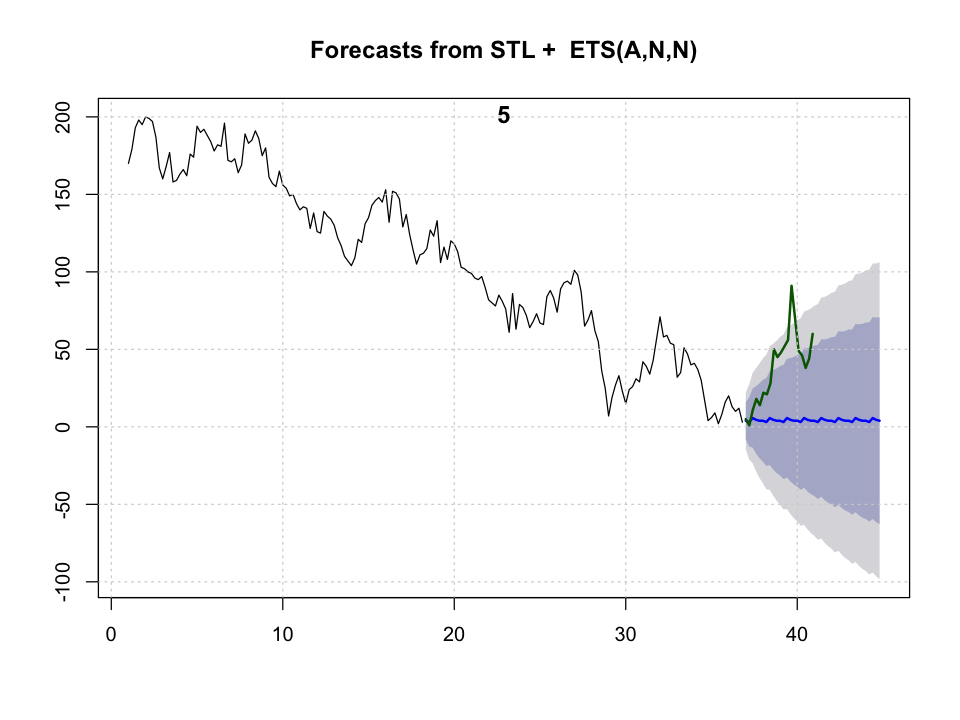

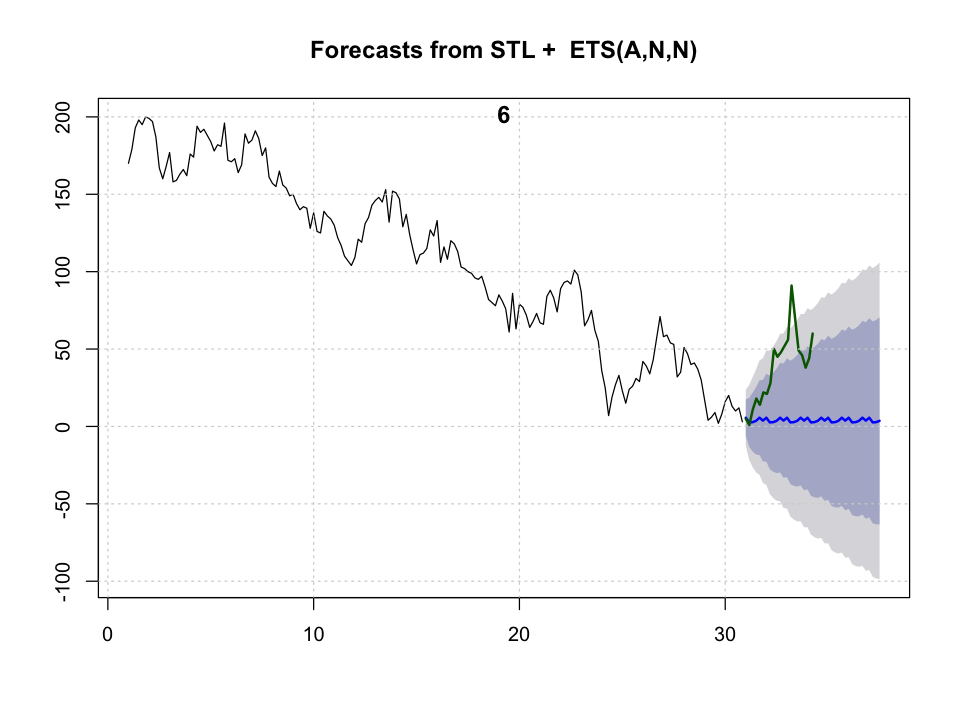

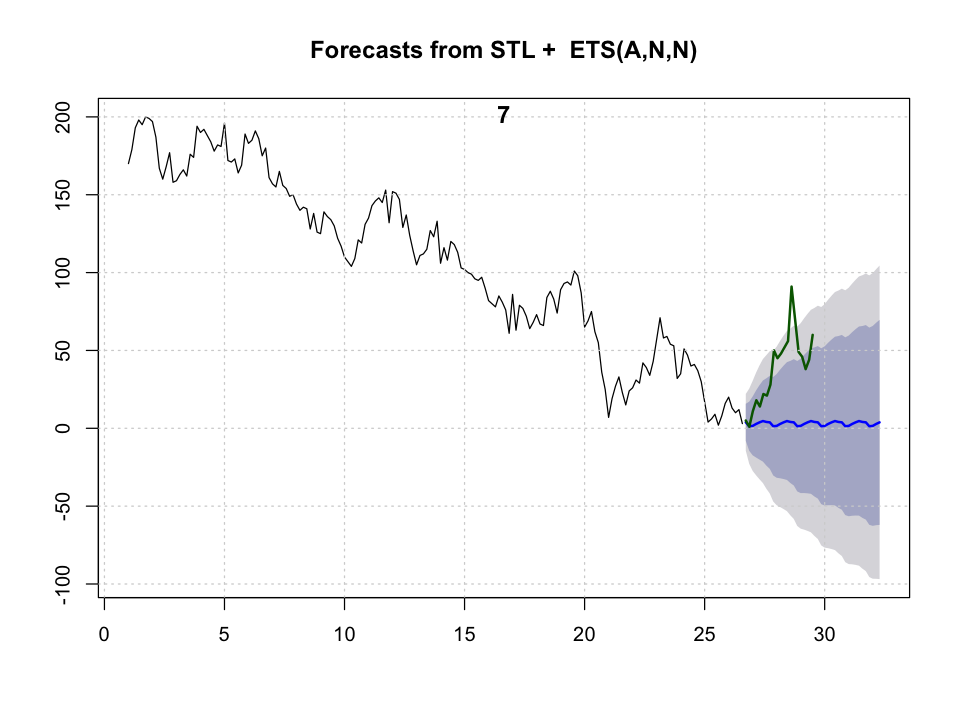

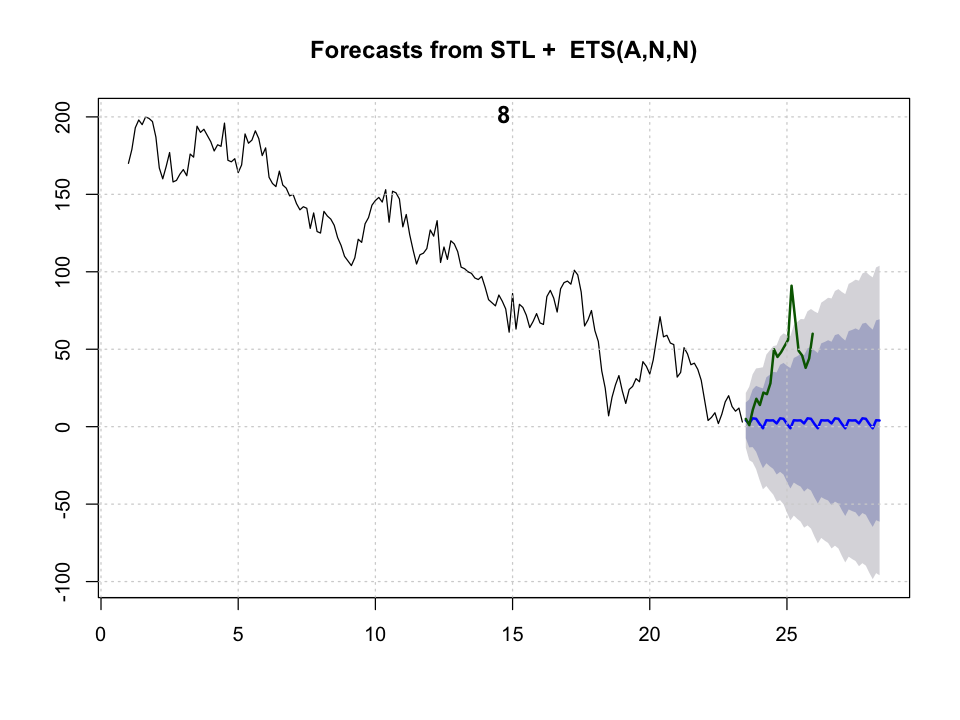

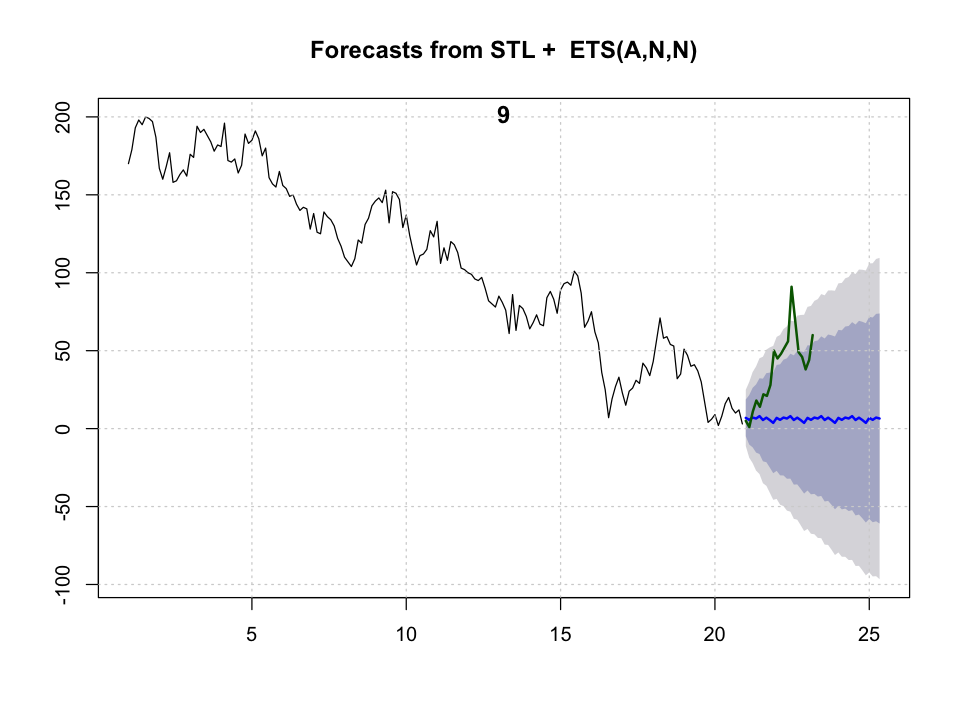

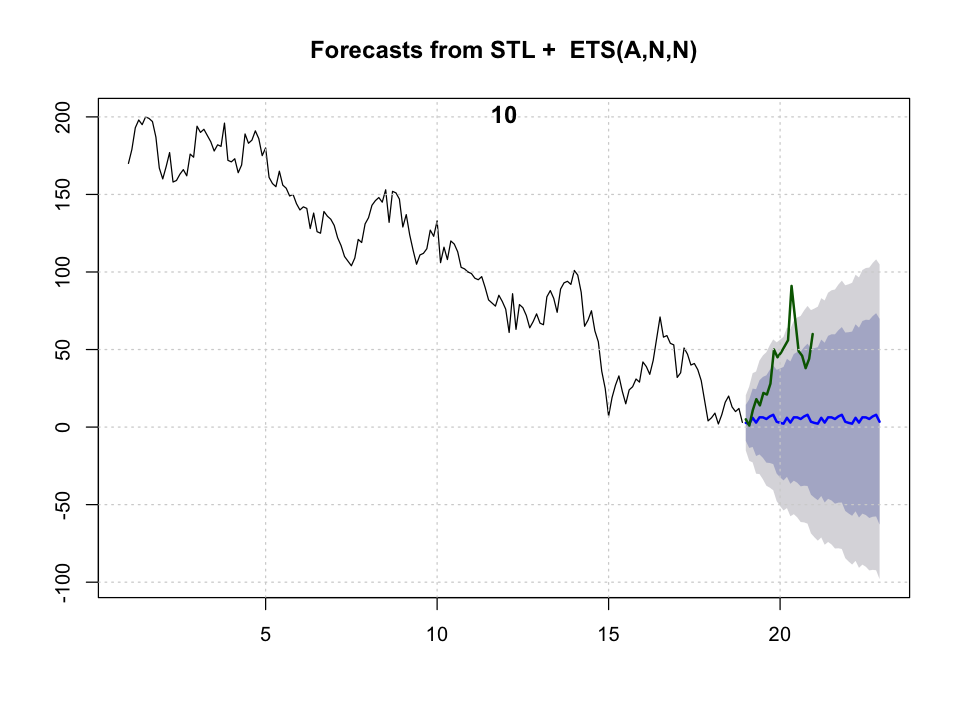

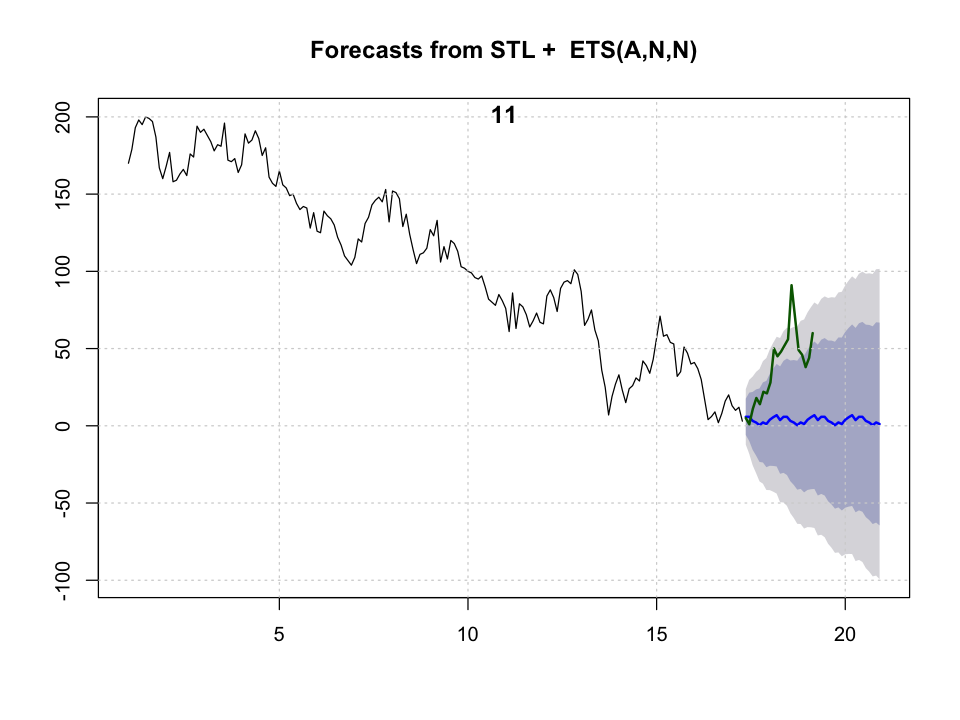

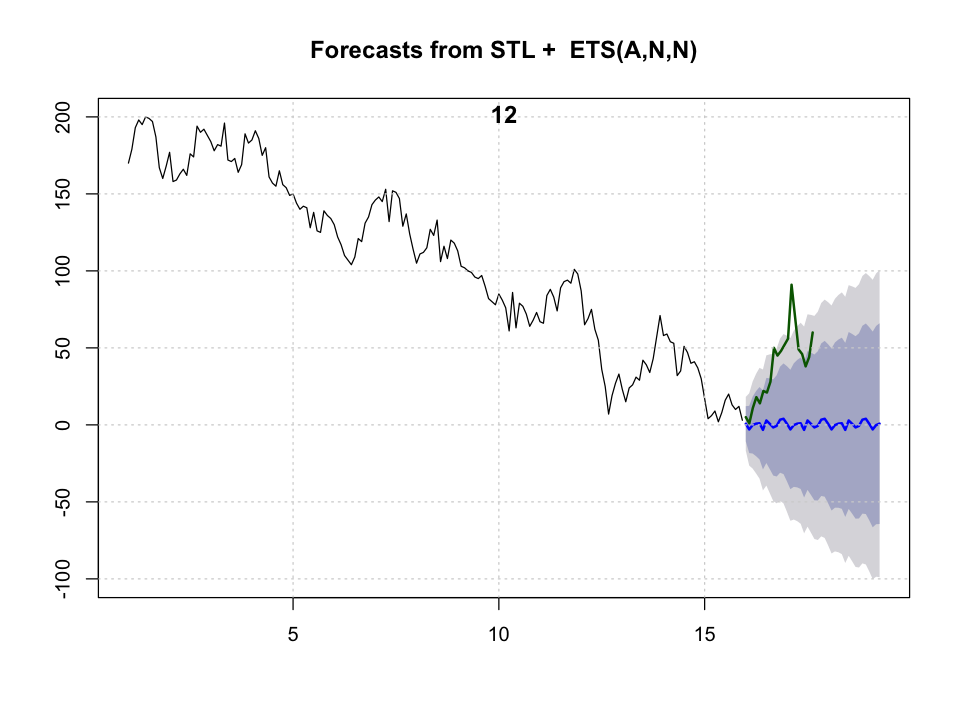

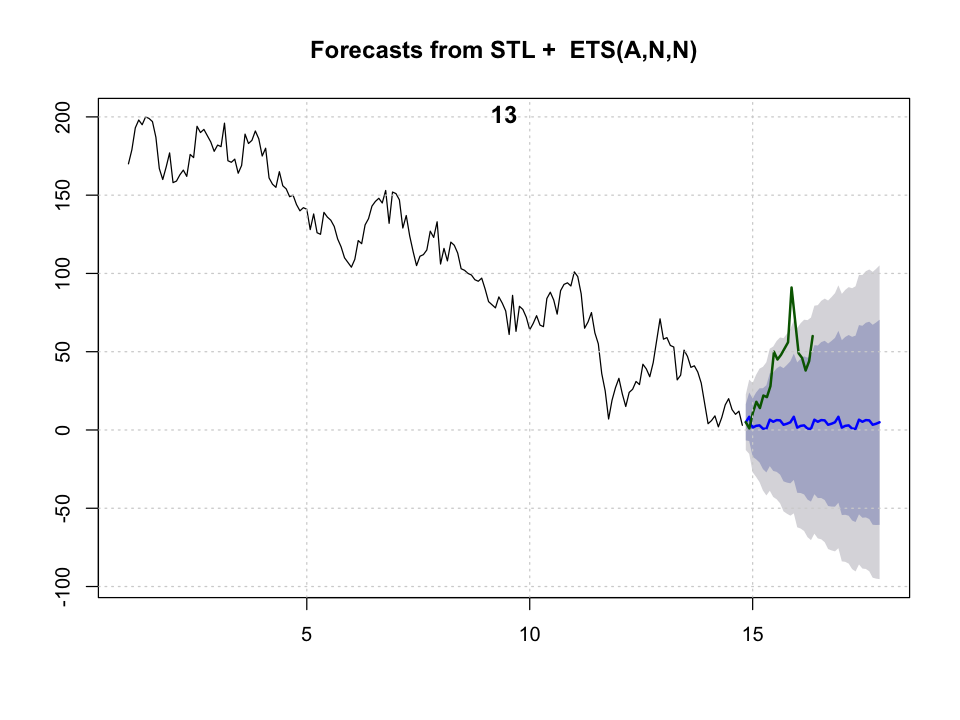

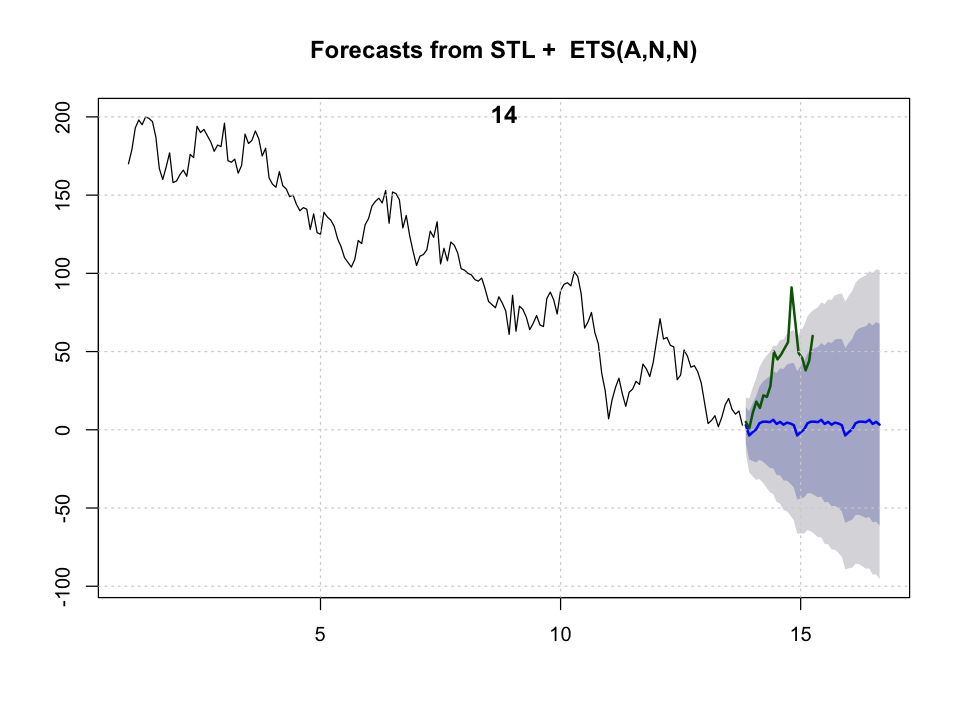

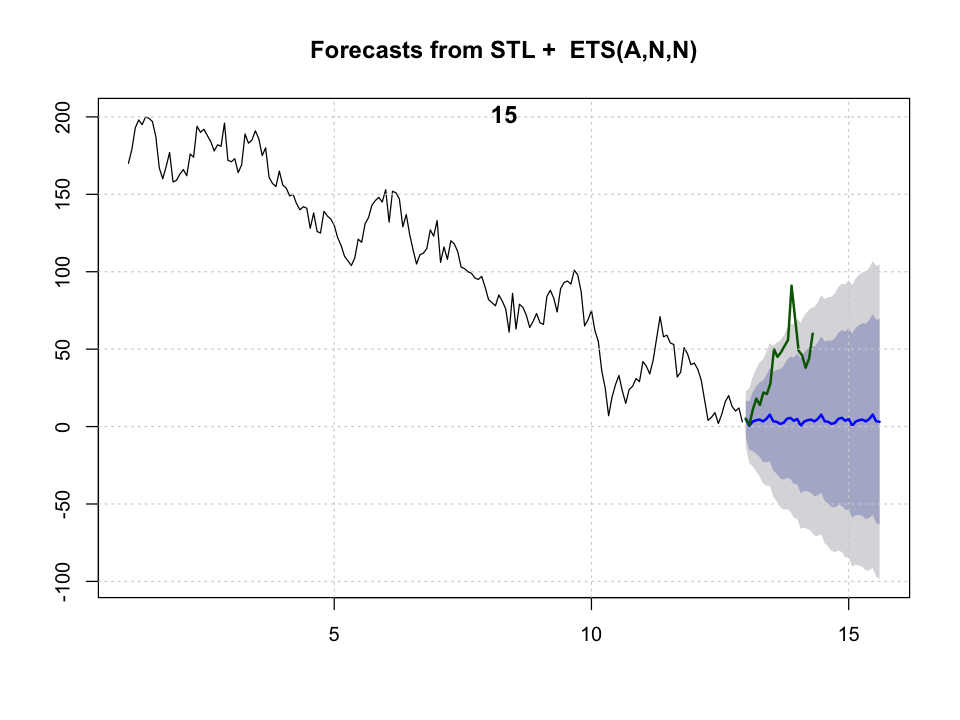

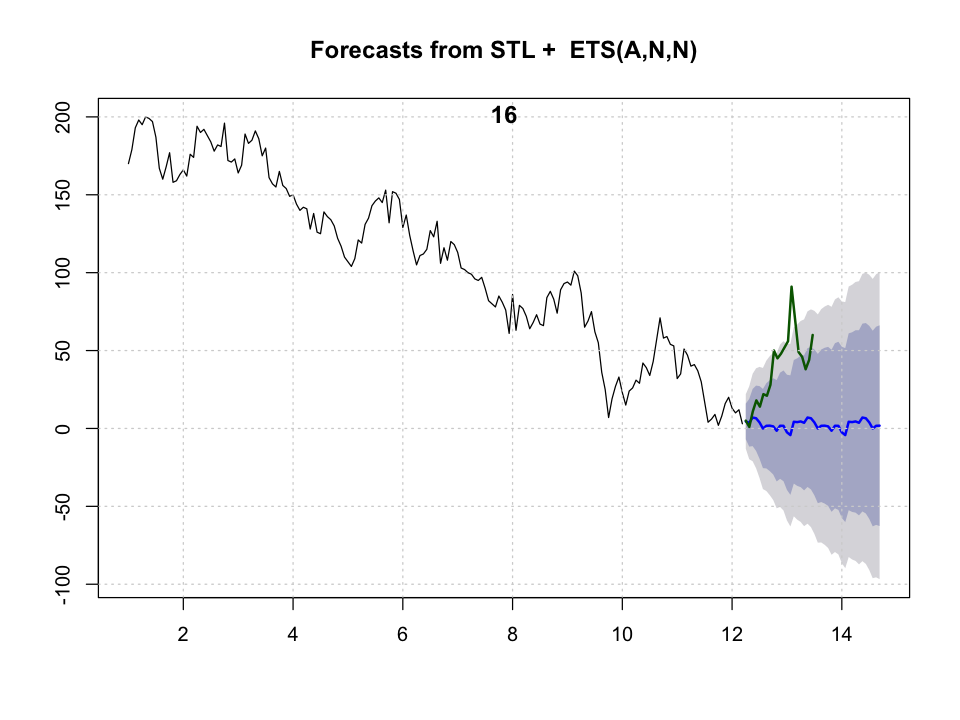

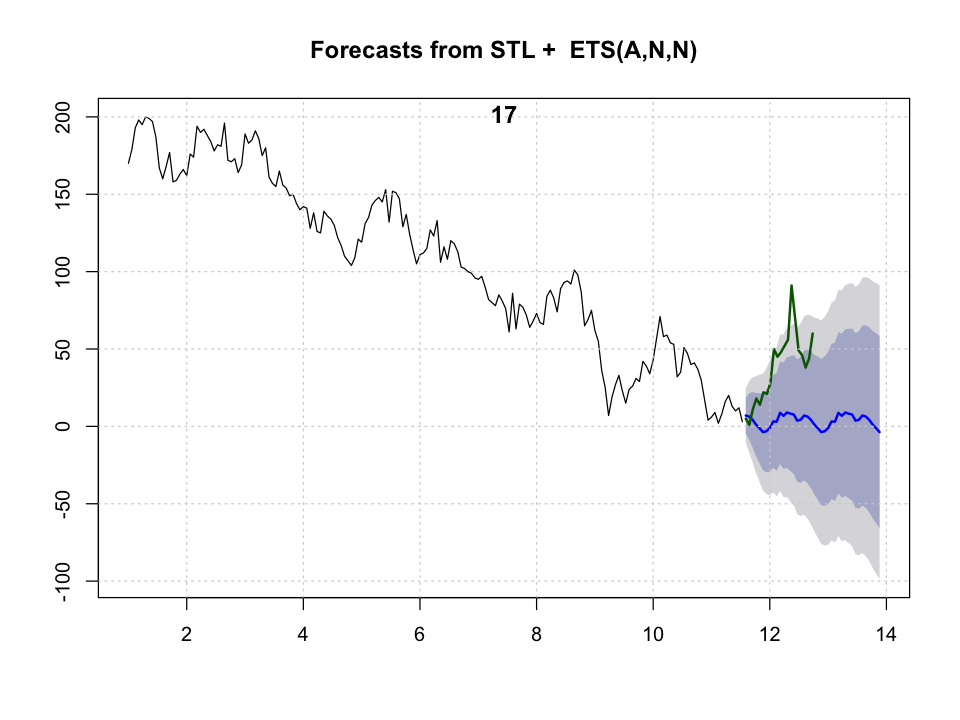

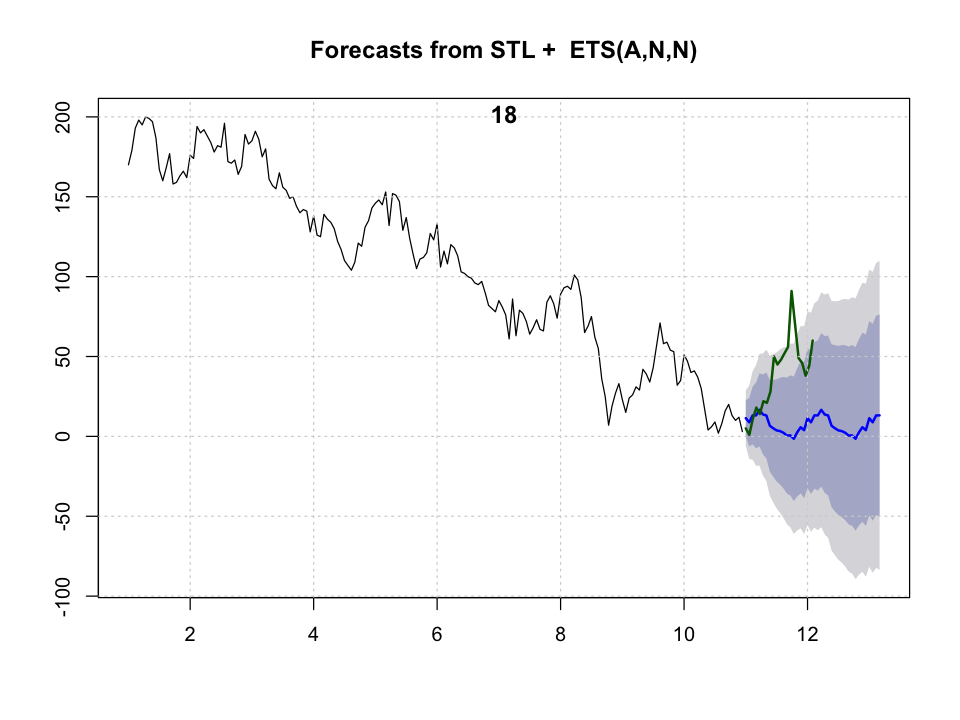

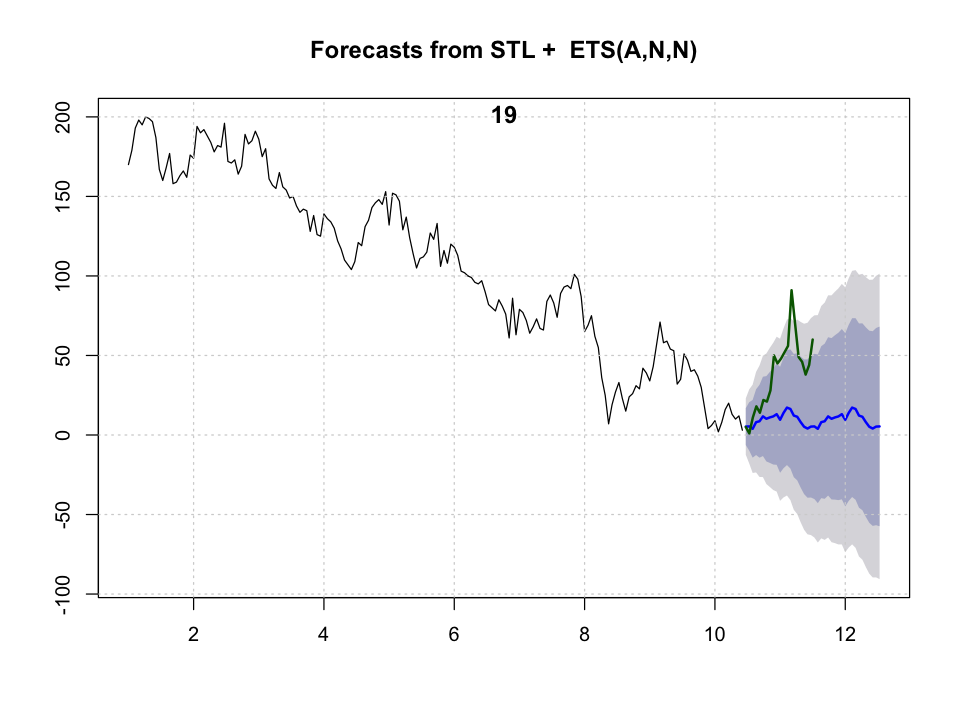

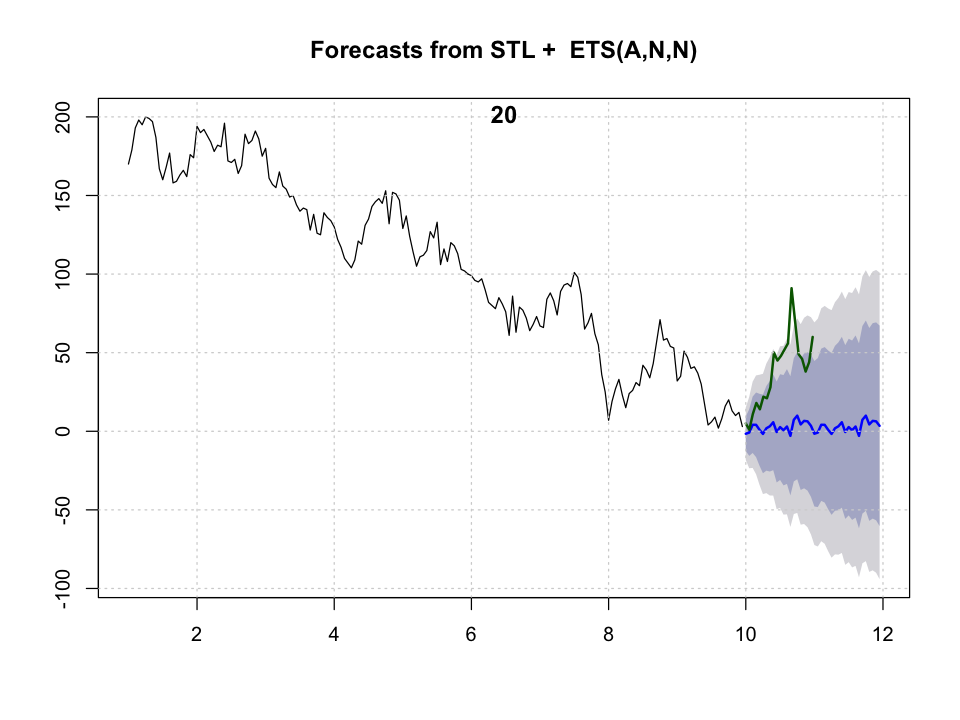

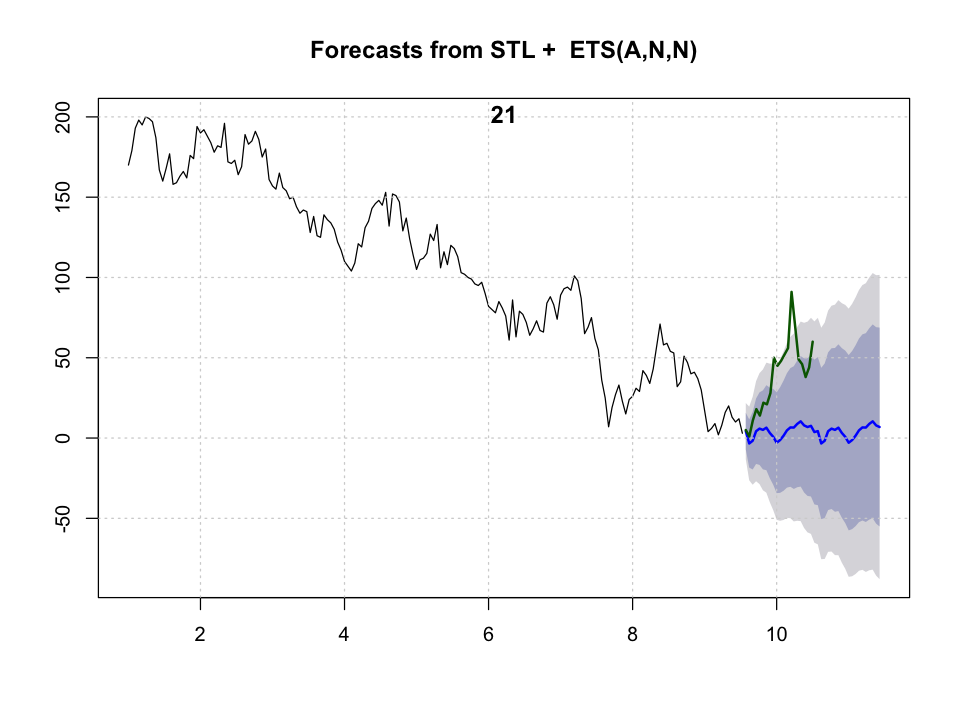

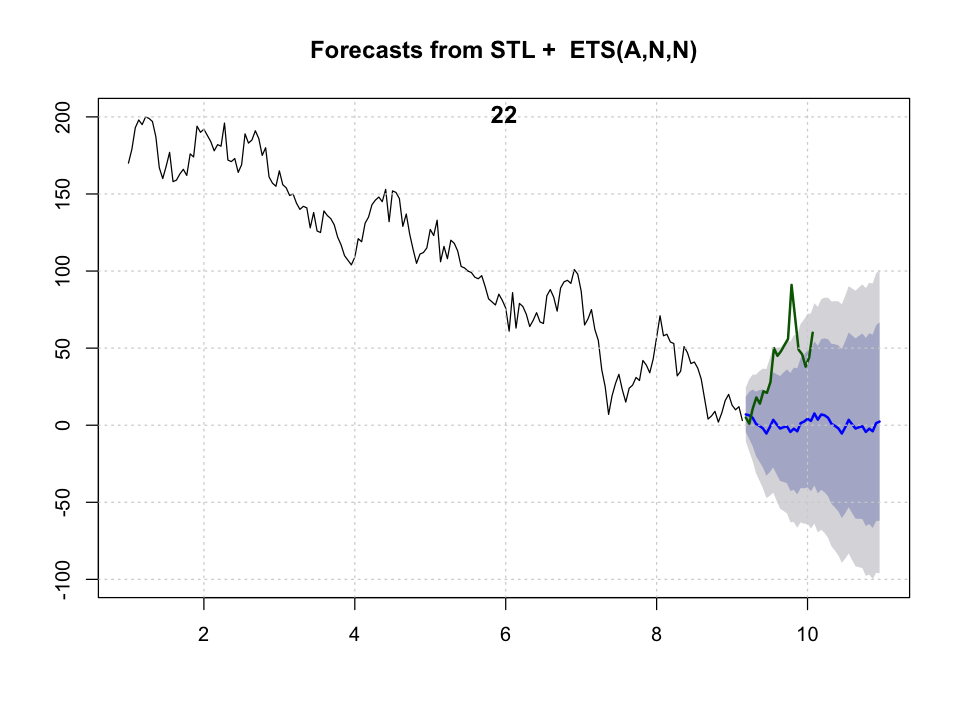

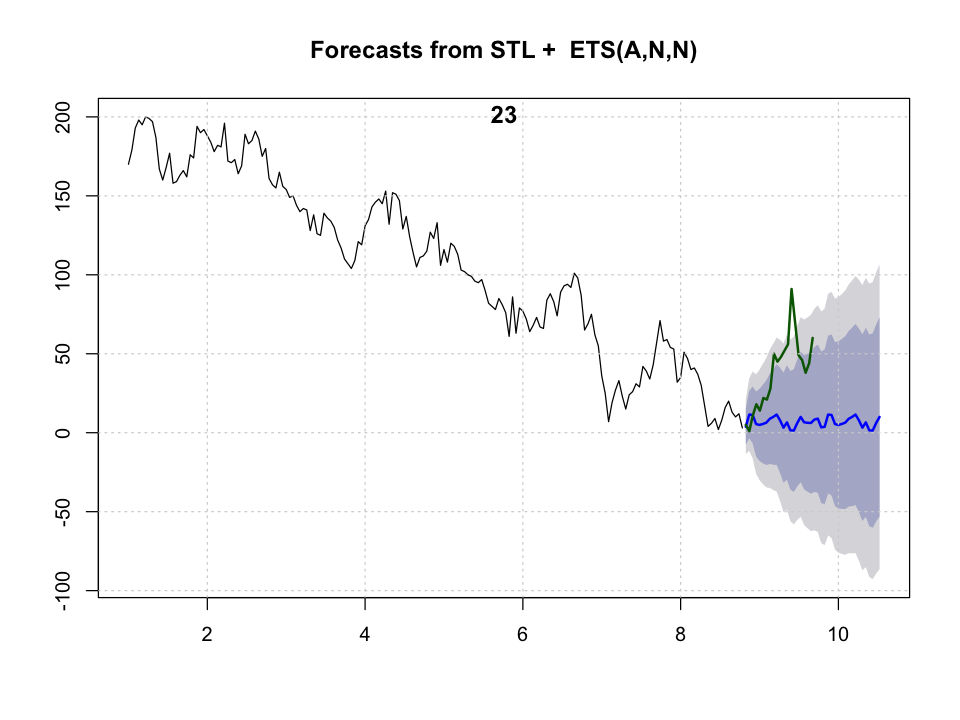

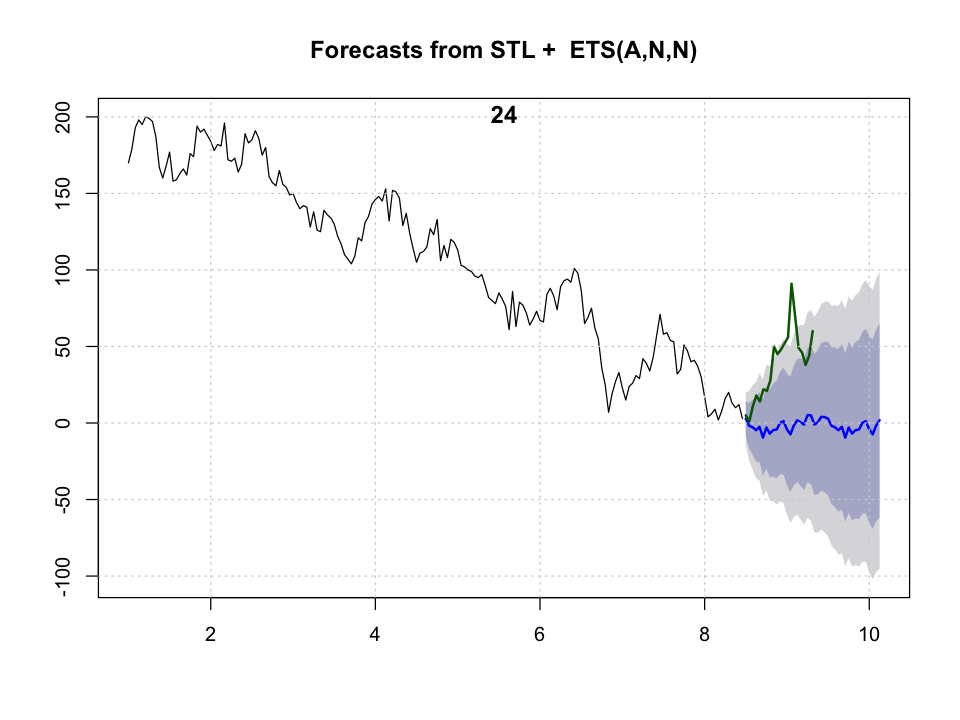

In [6]:
for (frequency in 5:24) {
    tSeries <- ts(data = train, frequency = frequency)
    fit_arima <- auto.arima(tSeries)
    options(repr.plot.width = 8, repr.plot.height = 6)
    stl.decompose <- stl(tSeries, s.window="periodic")
    stl_forecast <- forecast(stl.decompose, h = 2 * k)
    x_test = get_x_test(stl_forecast, frequency = frequency)
    plot(stl_forecast)
    lines(x_test, test, col = 'dark green', lwd = 2)
    lines(fit_arima$states[, 1], col = 'red', lwd = 2)
    grid()
    title(frequency, line = -1)
}

Здесь сложно сказать, с какой сезональностью вышло лучше, но все же значения в районе 20 выглядят по-лучше. Однако это подгон. В целом ни один способ не дал нормального предсказания. Проблема еще в том, что данные такие, что как раз на стыке тестовой и обучающей частей выбороки происходит изменение тренда.